In [2]:

import jax
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

[cuda(id=0)]


In [3]:
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))

# Computing the sine transform using the FFT

The sine transform should be an approximation of 

$$
b_k = \sqrt{2}\int_{0}^1 f(x)\sin(k\pi x)dx %= \frac{\sqrt{2}}{\pi}\int_{0}^\pi f\Big(\frac{y}{\pi}\Big)\sin(ky)dy
$$


 Define 
\begin{aligned}
\tilde{f} = \begin{cases}f(2x) \quad &0\leq x  \leq 1/2 \\
-f(2(1-x)) \quad & 1/2\leq x\leq 1 \end{cases}
\end{aligned}


Then 
\begin{aligned}
\int_{0}^{1} \tilde{f}(y)\exp(2k\pi i y)dy  &= \int_{0}^{1/2} \tilde{f}(y)\exp(2k\pi i y)dy -  \int_{1/2}^{1}\tilde{f}(y)\exp(2k\pi i y)dy\\
&= \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy -  \int_{1/2}^{1}f(2(1- y))\exp(2k\pi i y)dy\\
&=  \int_{0}^{1/2}f(2y)\exp(2k\pi i y)dy -  \int_{1/2}^{0}f(2y)\exp(2k\pi i (1-y))dy \\
&=  \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy +  \int_{0}^{1/2}f(2y)\exp(2k\pi i (1-y))dy \\
&=  \int_{0}^{1/2} f(2y)\exp(2k\pi i y)dy +  \int_{0}^{1/2}f(2y)\exp(-2k\pi iy)dy \\
&=  \int_{0}^{1/2} (f(2y)\exp(2k\pi i y)-\exp(-2k\pi iy)) dy \\
&=  2i\int_{0}^{1/2} f(2y)\sin(2k\pi y)  dy \\
&= i\int_{0}^{1} f(y)\sin(k\pi y)  dy 
\end{aligned}

Hence the sine transform can be found by extending the function in the above manner and computing the DFT which computes $\int_{0}^{1} \tilde{f}(y)\exp(-2k\pi i y)dy\approx \frac{1}{N}\alpha_k$ . Hence
$$
b_k =\frac{\sqrt{2}}{i}\int_{0}^{1} \tilde{f}(y)\exp(2k\pi i y)dy \approx -\frac{1}{\sqrt{2}Ni}\alpha_k
$$

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [4]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    # The frequency starts at 0
    frequencies = jnp.arange(0, c.shape[0])
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [5]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [6]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**13
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
print(n_coef)

frequencies = jnp.arange(0, n_coef)
coef_f = jnp.hstack([0.0, random.normal(key, shape= (n_coef-1,))]) # We set the first coefficient to zero as it corresponds to the constant term
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

8192


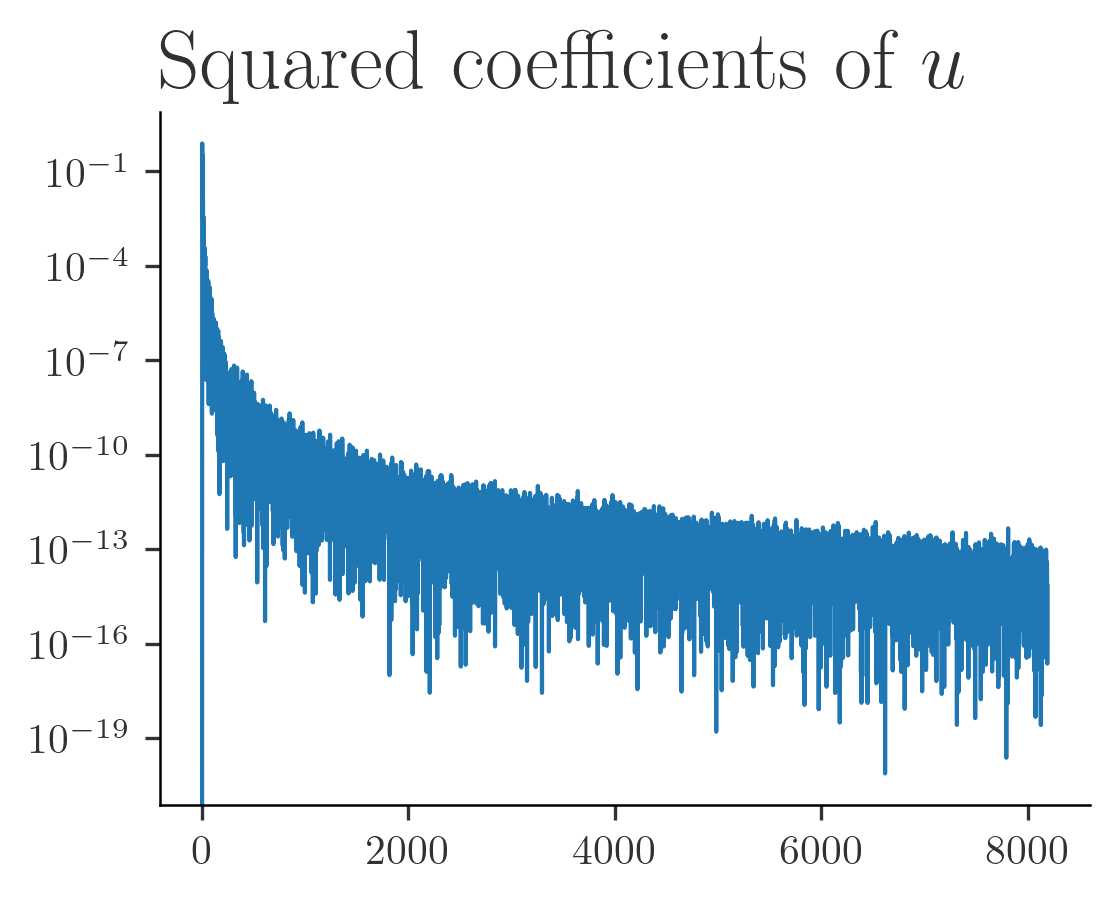

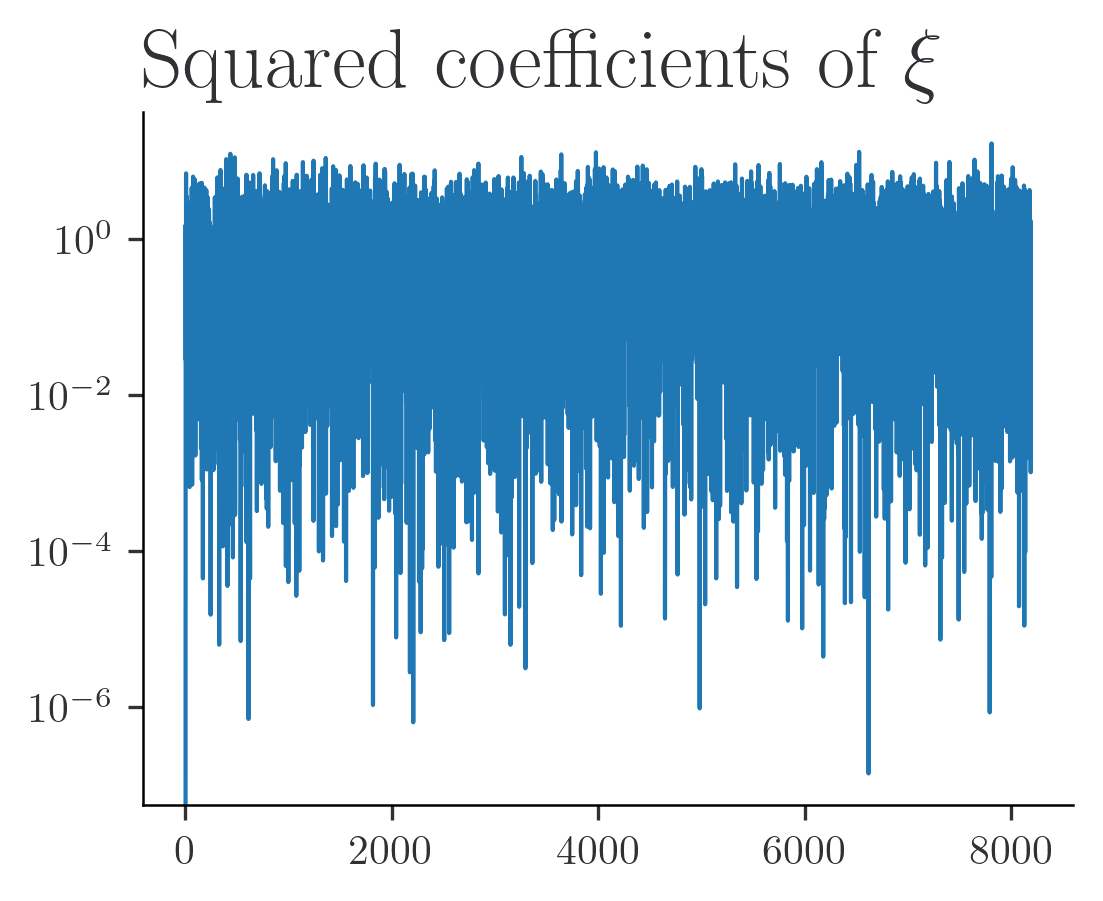

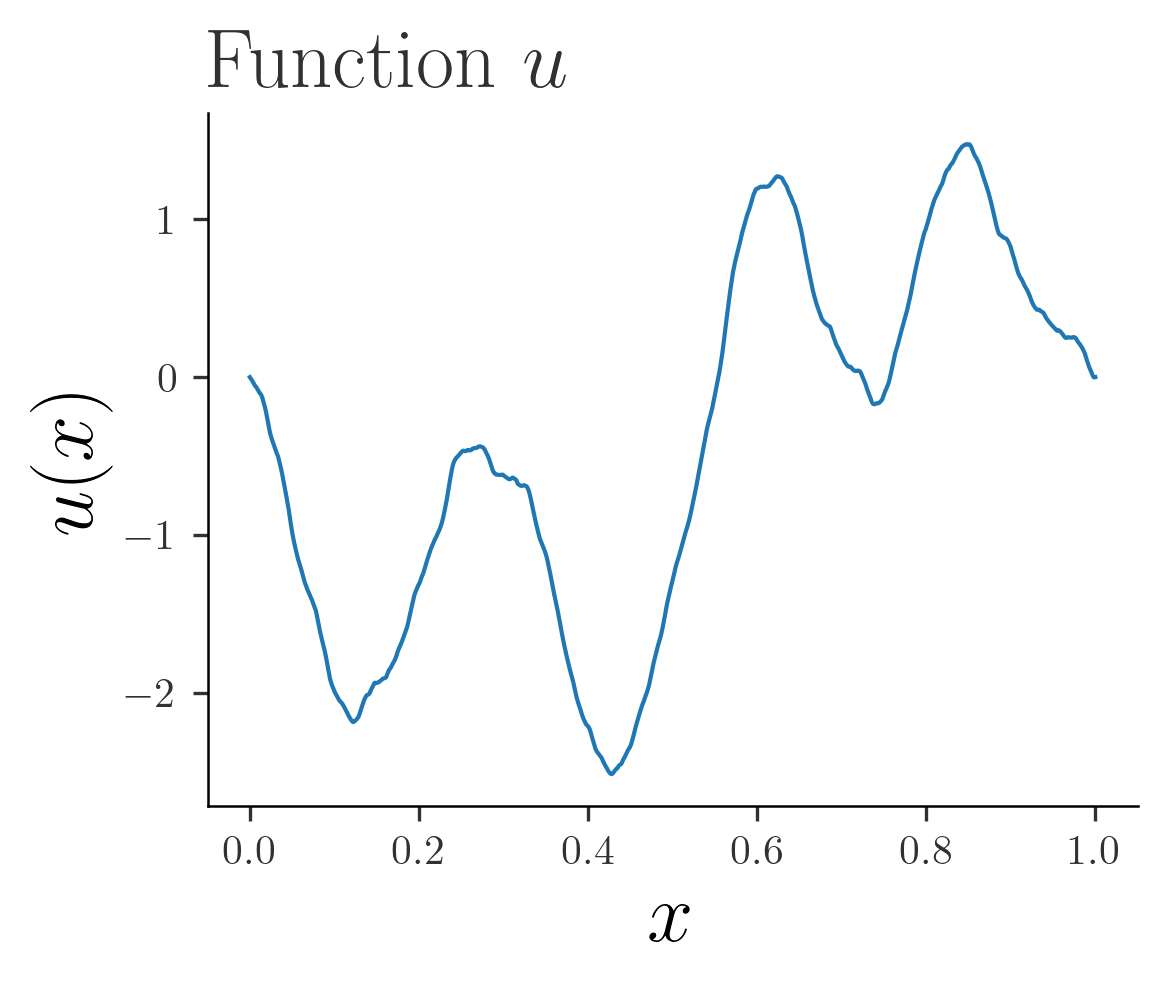

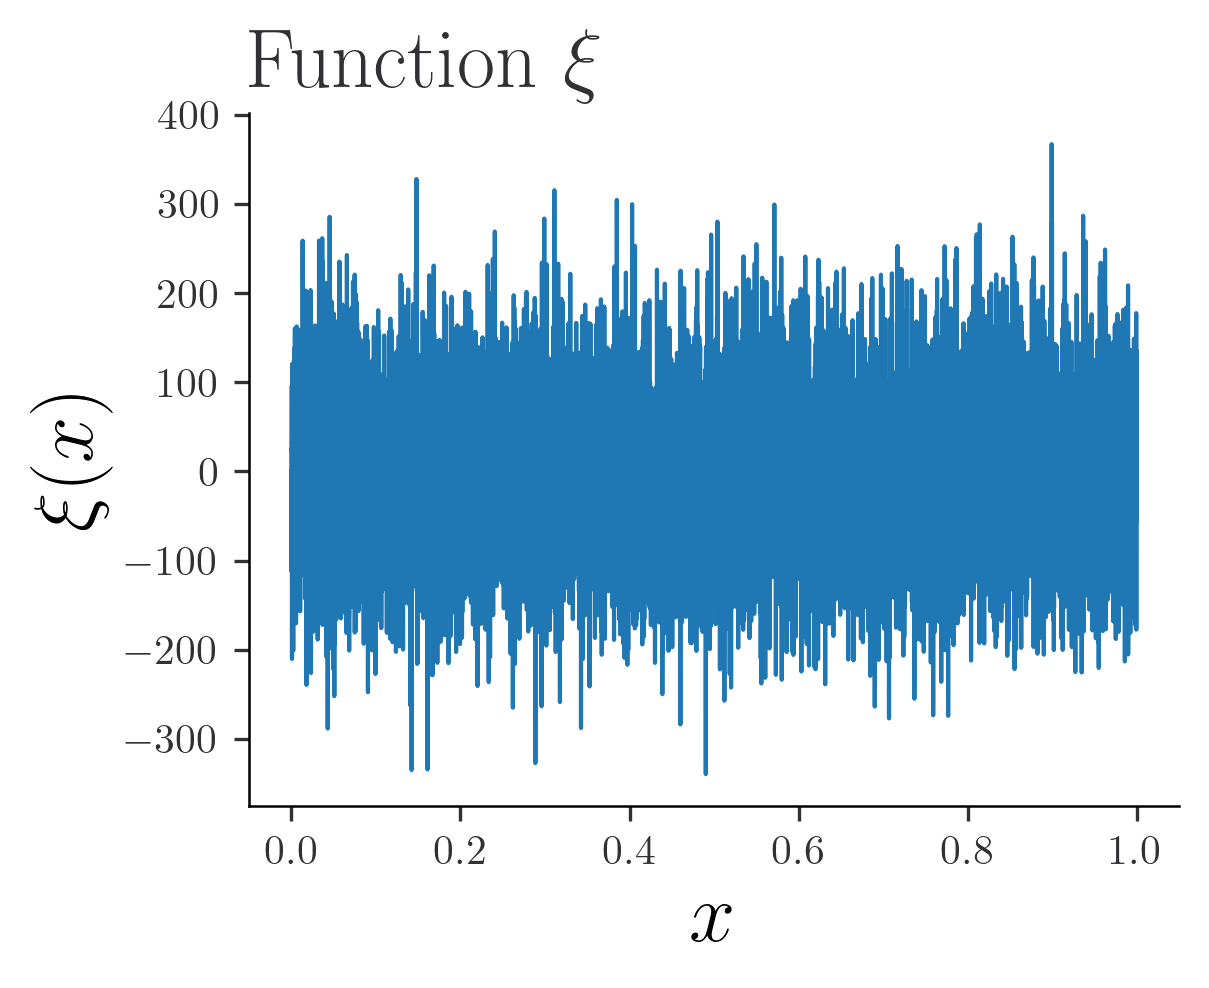

In [7]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

## We compute the accuracy of the DST

In [8]:
u_transform = discrete_sine_transform(u_values)
f_transform = discrete_sine_transform(f_values)

In [9]:
# We observe good recovery of u, not so good of f (which is expected)
jnp.mean(jnp.abs(u_transform[:-1] - coef_u)), jnp.mean(jnp.abs(f_transform[:-1] - coef_f))

(Array(1.40867474e-06, dtype=float64), Array(0.50384932, dtype=float64))

In [10]:
u_transform[:-1]

Array([-0.00000000e+00, -4.66567208e-01, -8.81588309e-01, ...,
        5.38297270e-11, -4.44830745e-12,  2.33205833e-11], dtype=float64)

In [11]:
coef_u

Array([ 0.00000000e+00, -4.66405723e-01, -8.81663398e-01, ...,
        4.84041776e-09, -3.80672092e-08,  8.17818791e-08], dtype=float64)

In [12]:
f_transform[:-1]

Array([-0.00000000e+00, -5.12642382e-01, -1.22967513e+00, ...,
        1.49443513e-04, -1.52048647e-04,  8.54336758e-05], dtype=float64)

In [13]:
coef_f

Array([ 0.        , -0.51243812, -1.22973016, ...,  0.03203645,
       -0.25201051,  0.54154026], dtype=float64)

# Computing a solution

In [14]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y
b =lambda x : jnp.ones_like(x)*1.0

In [15]:
coef_f.shape

(8192,)

In [16]:
coef_f

Array([ 0.        , -0.51243812, -1.22973016, ...,  0.03203645,
       -0.25201051,  0.54154026], dtype=float64)

In [17]:
n_meas = 2**10
domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)
length_scale = 1.0

In [18]:
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

In [19]:
vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))

In [20]:
theta_22_sine = vmap_dst(vmap_dst(theta_22).T)
theta_22_sine = theta_22_sine[:-1, :-1] # remove the last spurious element
theta_12_sine = vmap_dst(theta_12)
theta_12_sine = theta_12_sine[:, :-1] # remove the last spurious element
theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

In [21]:
jnp.linalg.eigh(theta)[0][0] # This is PSD!

Array(1.29828604e-16, dtype=float64)

In [22]:
rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
nugget = jnp.concatenate([jnp.zeros_like(boundary), 1e-8*jnp.ones(n_meas)])
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

In [23]:
K = vmap_kernel(domain_finest, boundary, length_scale)
K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
K_interior = K_interior[:, :-1] # remove the last spurious element
K_eval = jnp.block([K, K_interior])
pred = K_eval@alpha

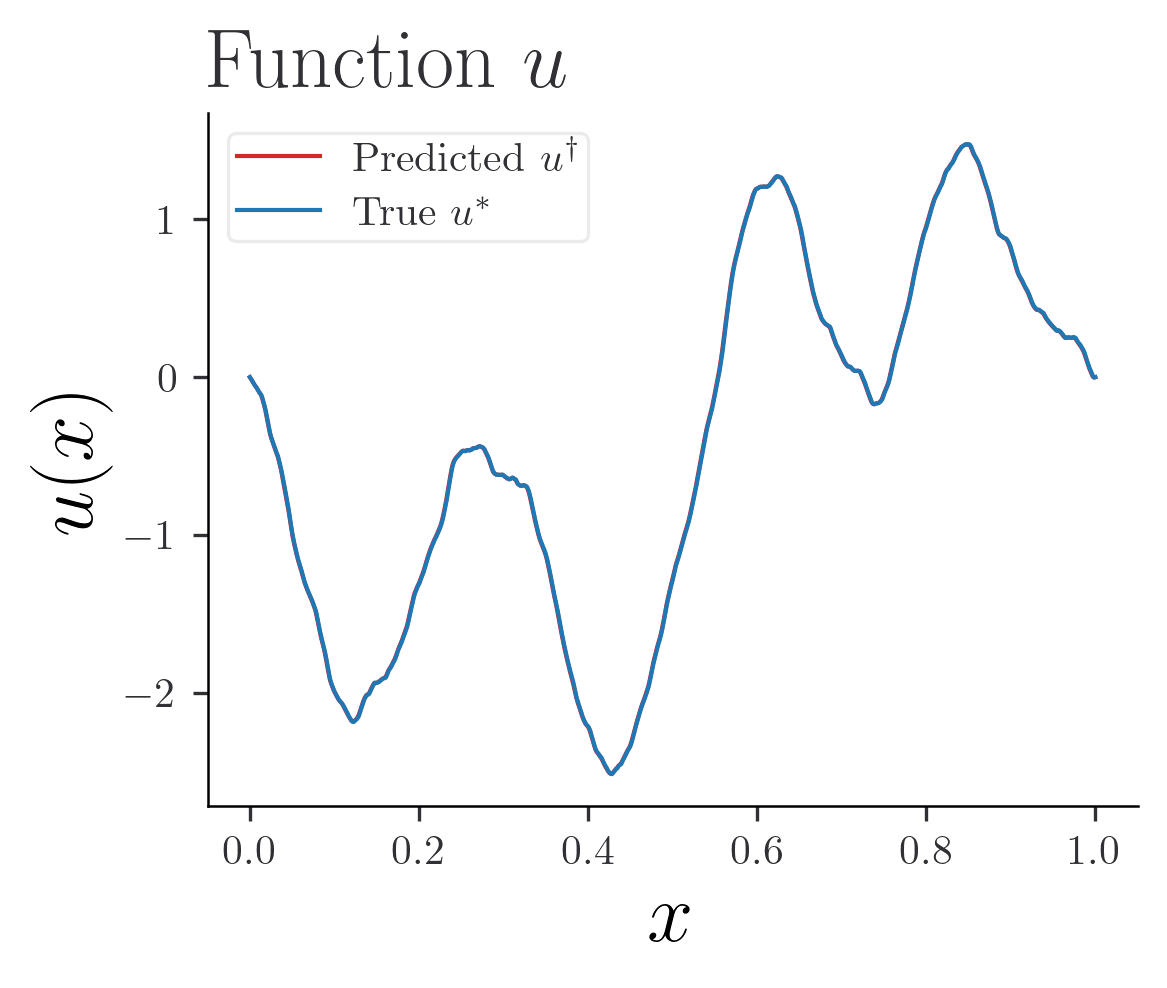

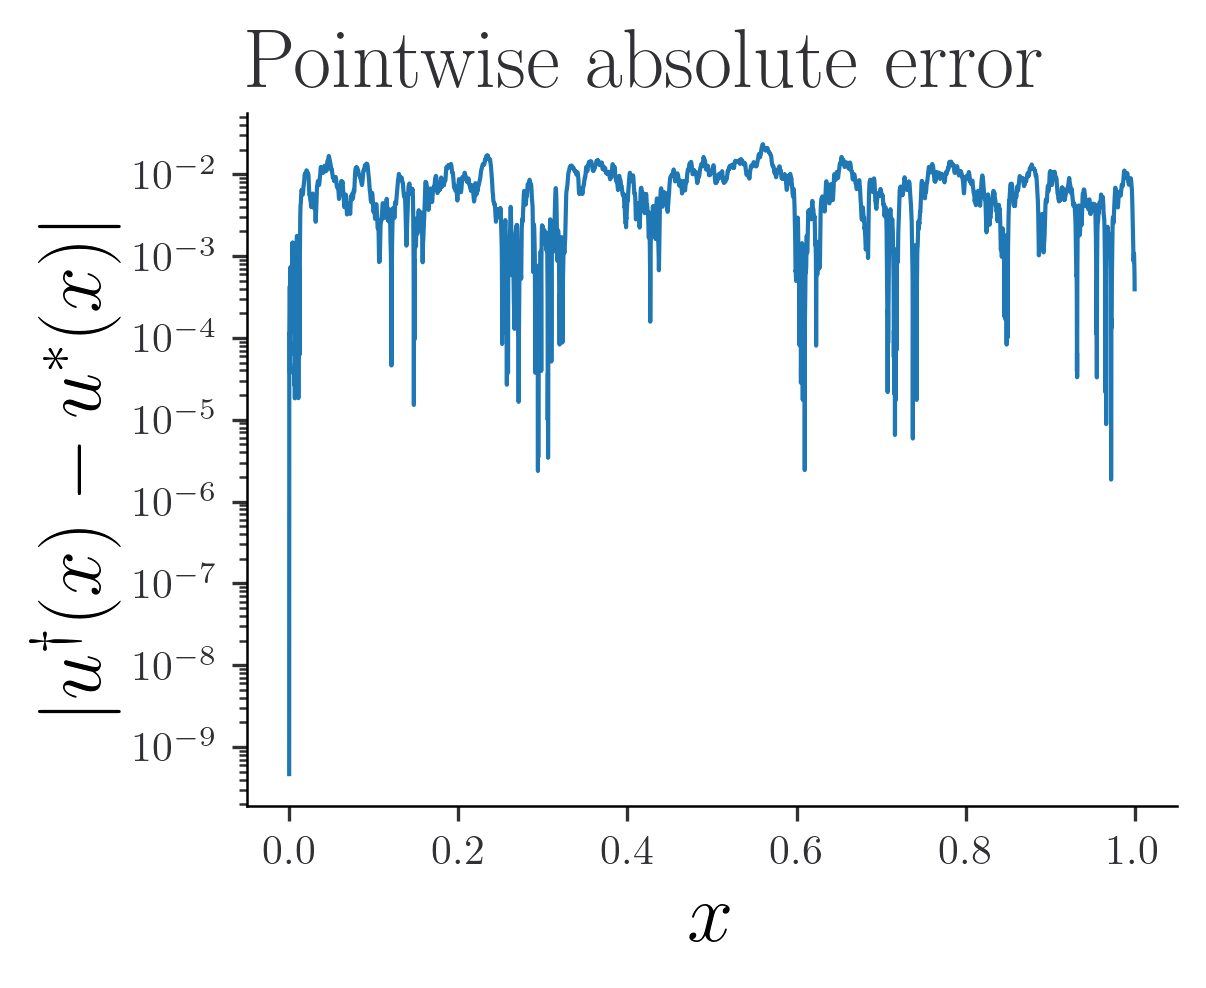

In [24]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [25]:
# Computing the error in the Fourier domain
pred_transform = discrete_sine_transform(pred)[:-1]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.007166351335230811 0.0058023551221772


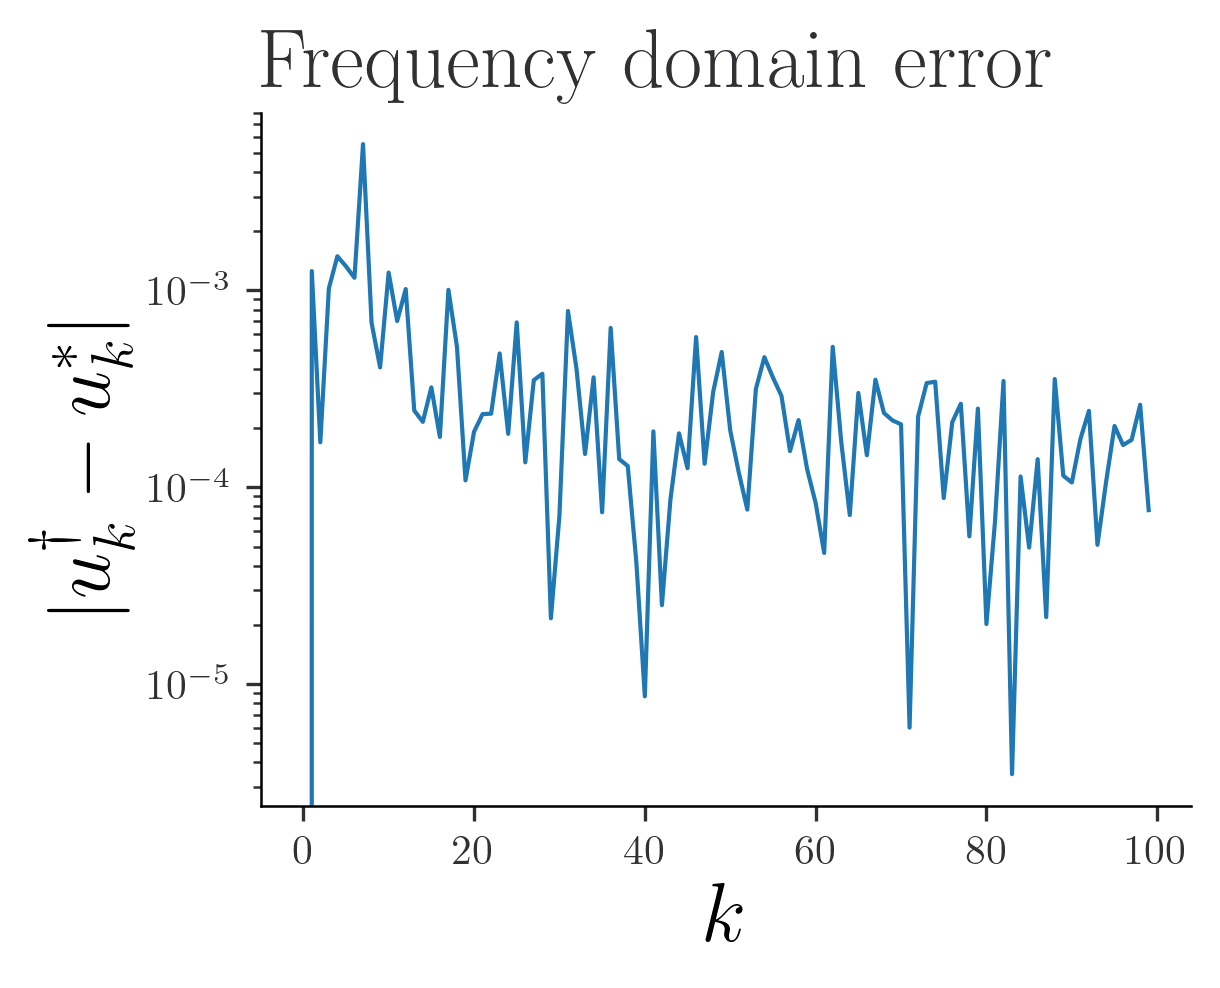

In [26]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

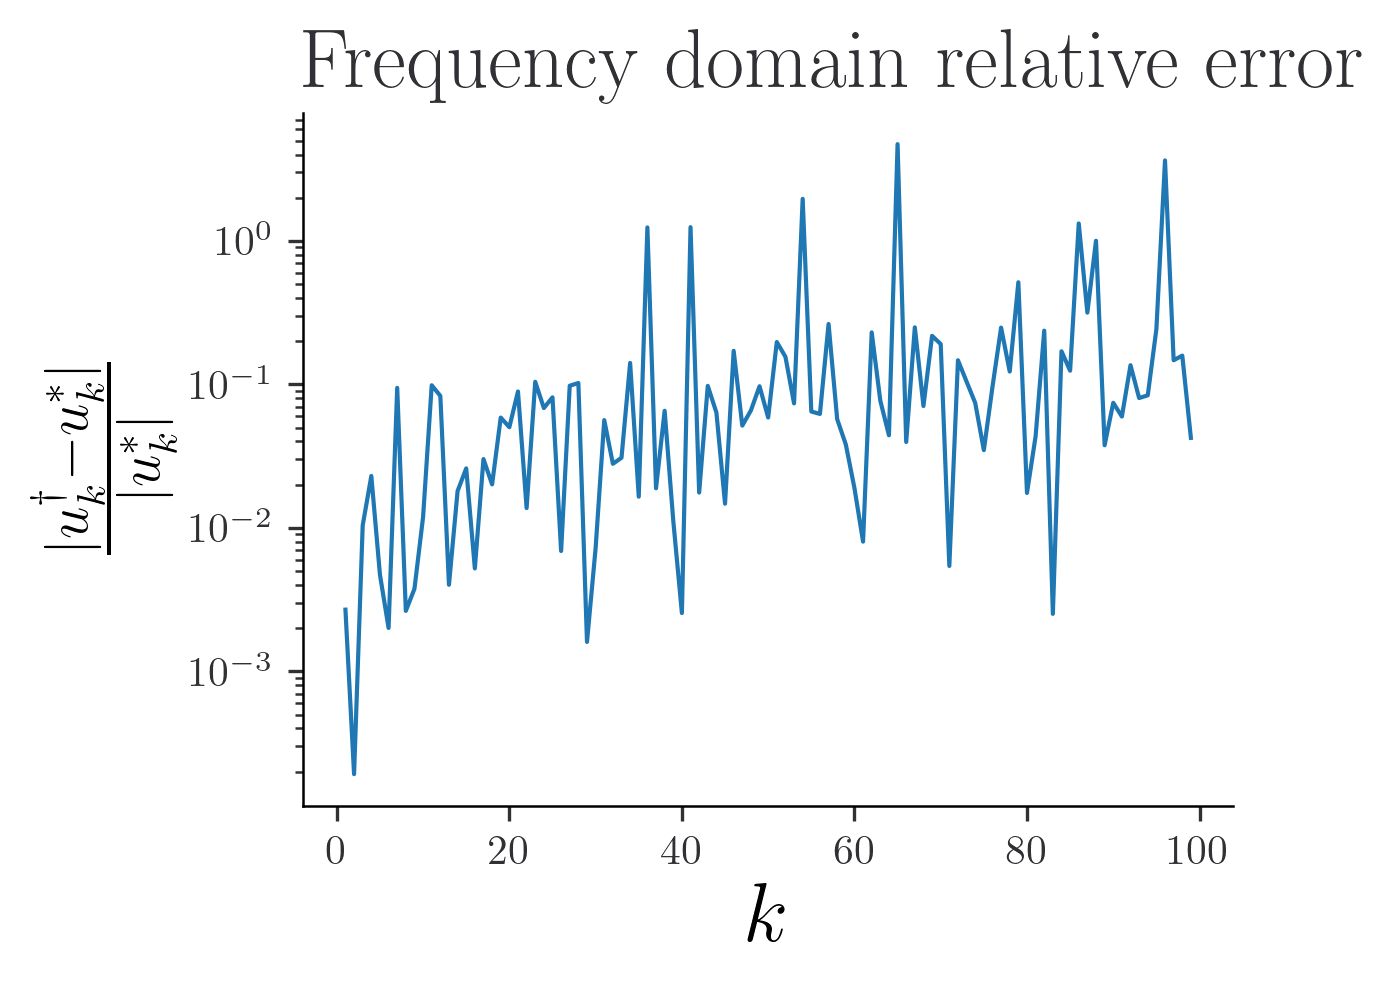

In [27]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# Computing error rates

In [87]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-10


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)
    theta_22_sine = theta_22_sine[:-1, :-1] # remove the last spurious element
    theta_12_sine = vmap_dst(theta_12)
    theta_12_sine = theta_12_sine[:, :-1] # remove the last spurious element
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior[:, :-1] # remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = discrete_sine_transform(pred)[:-1]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:04,  1.72it/s]

32


 22%|██▏       | 2/9 [00:01<00:03,  1.87it/s]

64


 33%|███▎      | 3/9 [00:01<00:03,  1.97it/s]

128


 44%|████▍     | 4/9 [00:02<00:02,  2.03it/s]

256


 56%|█████▌    | 5/9 [00:02<00:01,  2.07it/s]

512


 67%|██████▋   | 6/9 [00:02<00:01,  2.10it/s]

1024


 78%|███████▊  | 7/9 [00:03<00:00,  2.11it/s]

2048


 89%|████████▉ | 8/9 [00:03<00:00,  2.12it/s]

4096


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


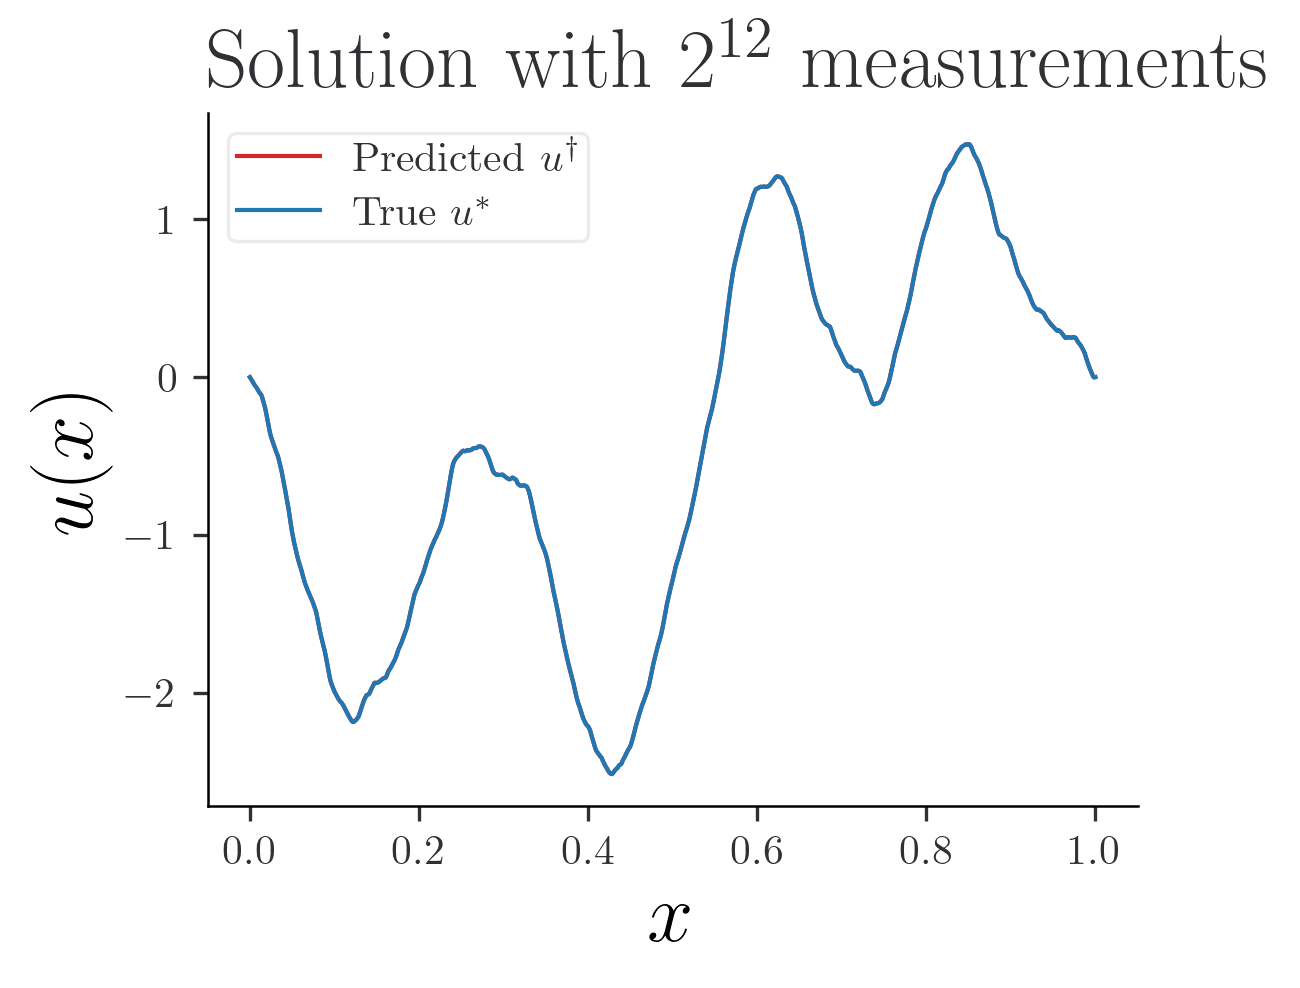

In [88]:
figure = plt.figure(figsize=(width, height))

plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


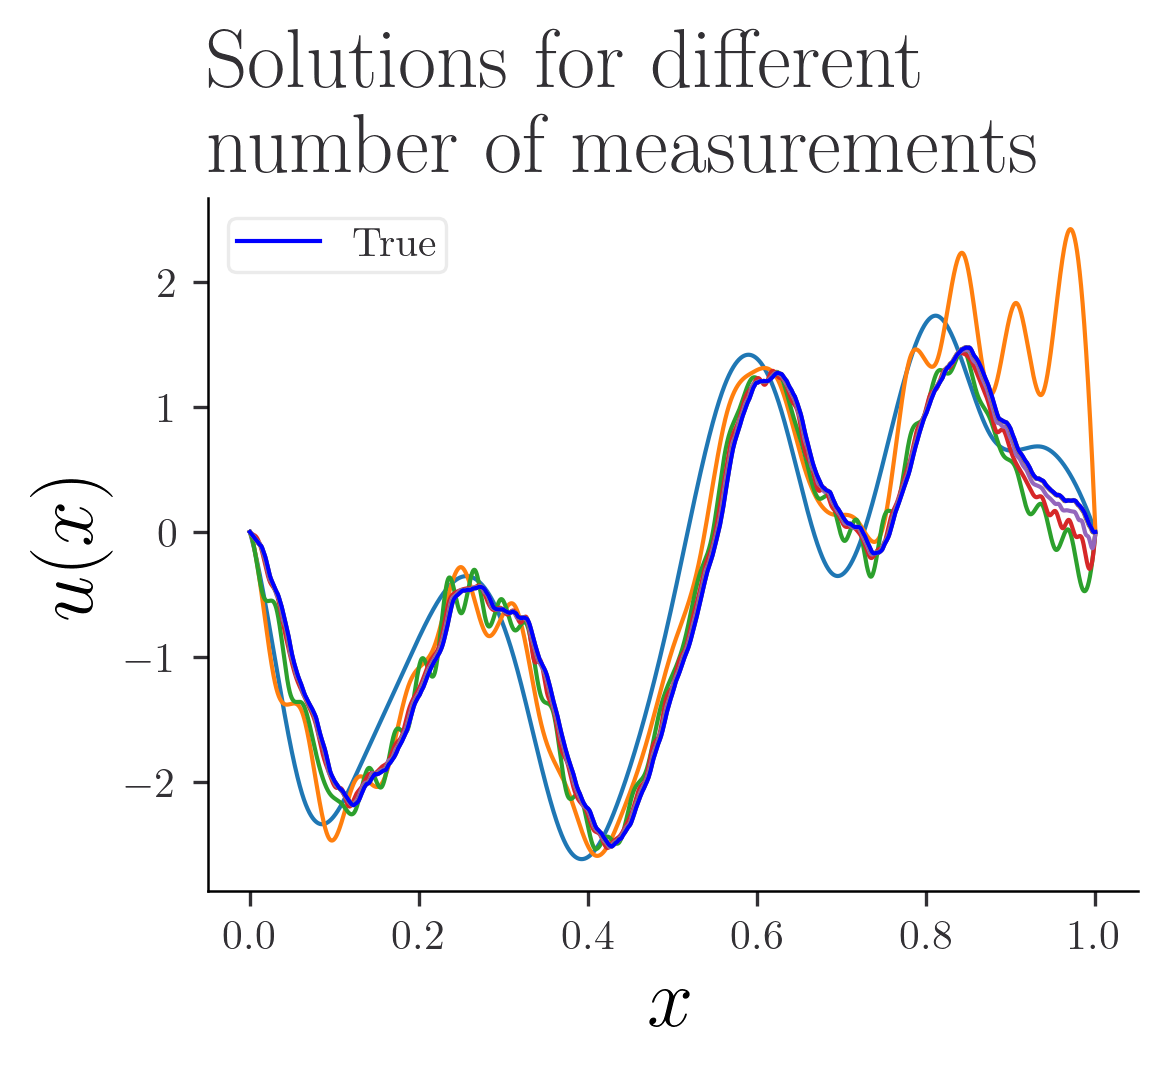

In [89]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [90]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.181


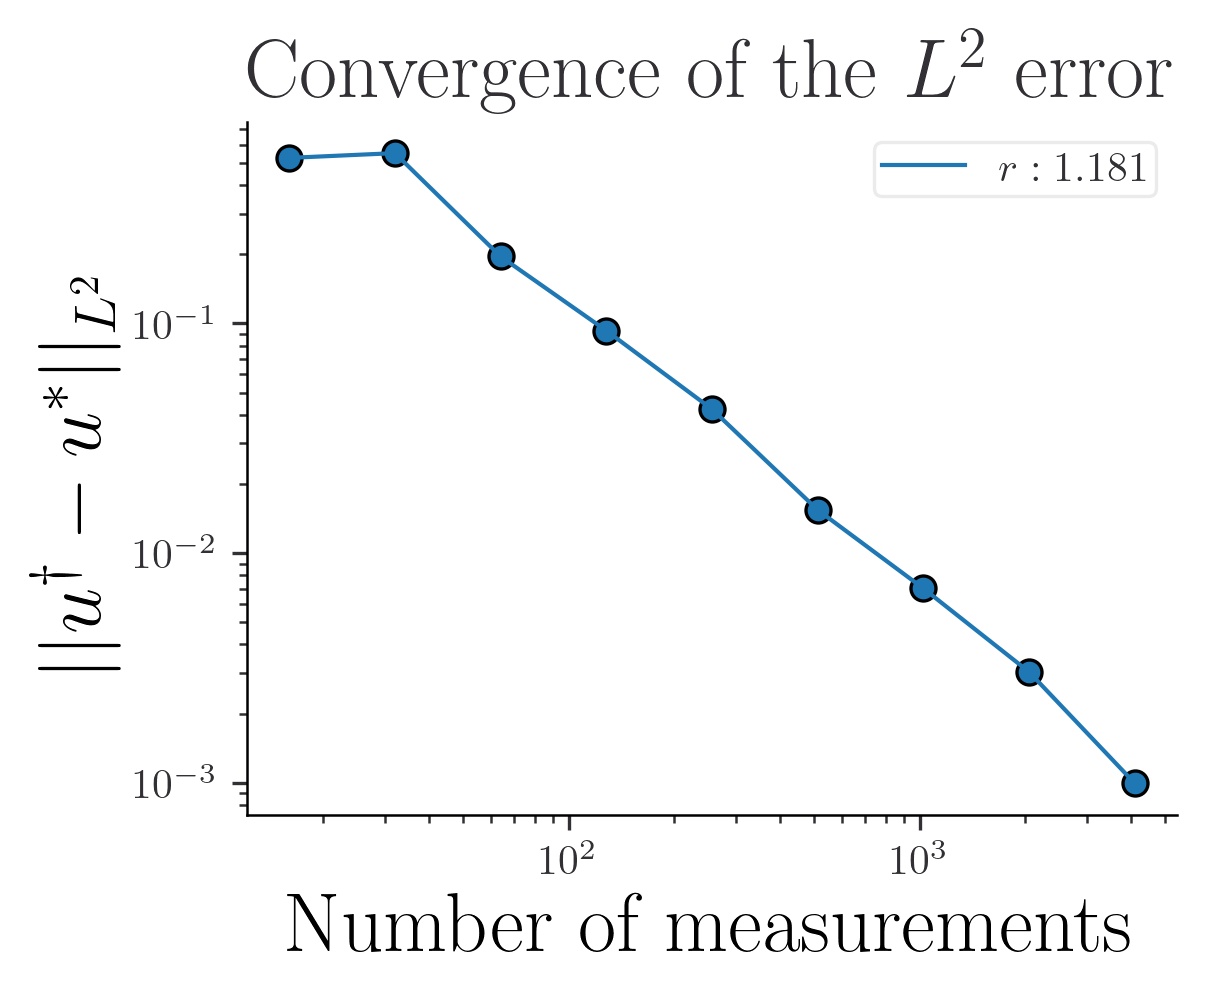

In [91]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [92]:
error

Array([0.52566098, 0.55125493, 0.19568925, 0.0930427 , 0.04233174,
       0.01542341, 0.00701892, 0.00303909, 0.0009958 ], dtype=float64)

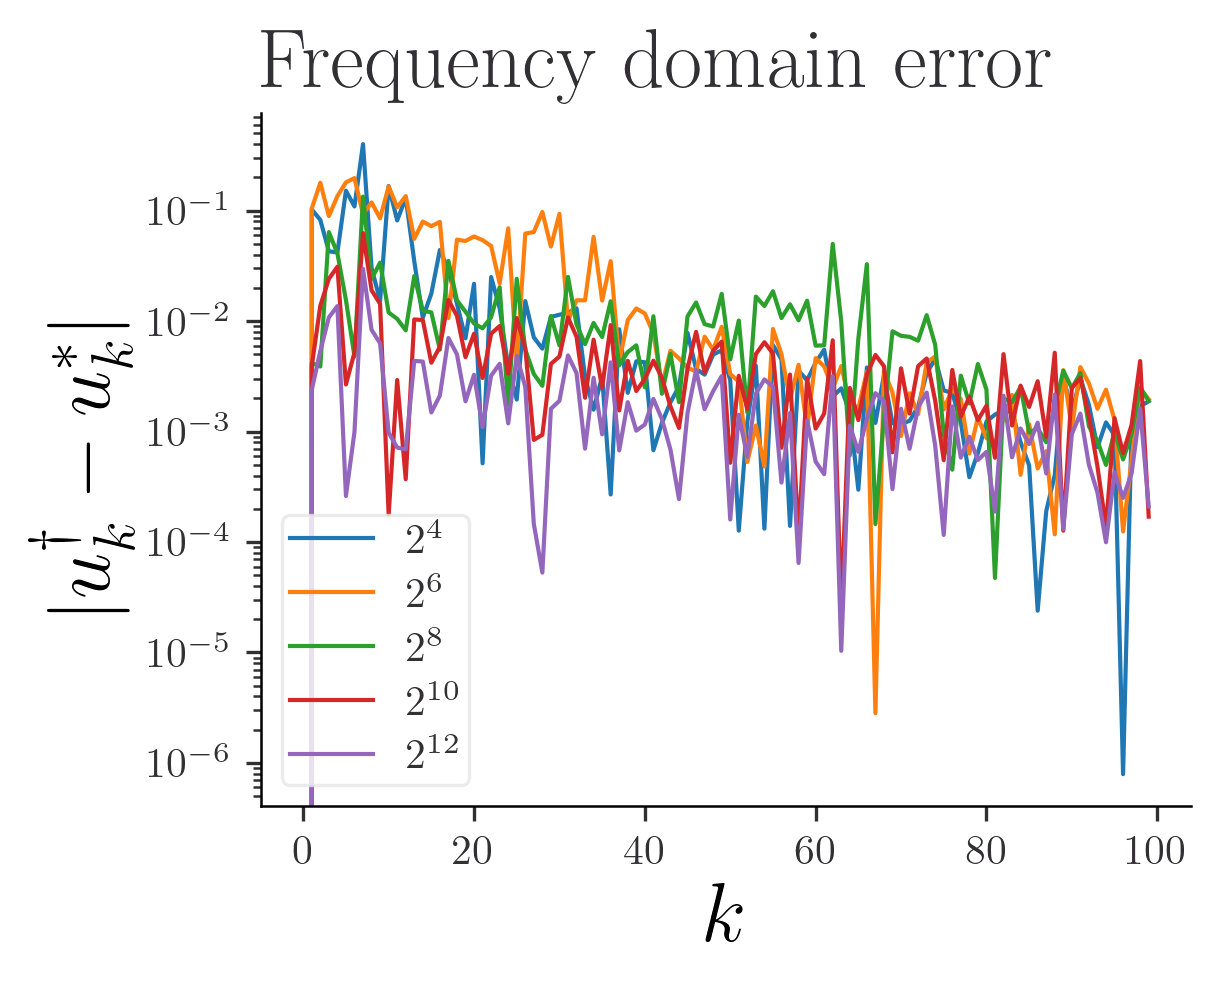

In [93]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


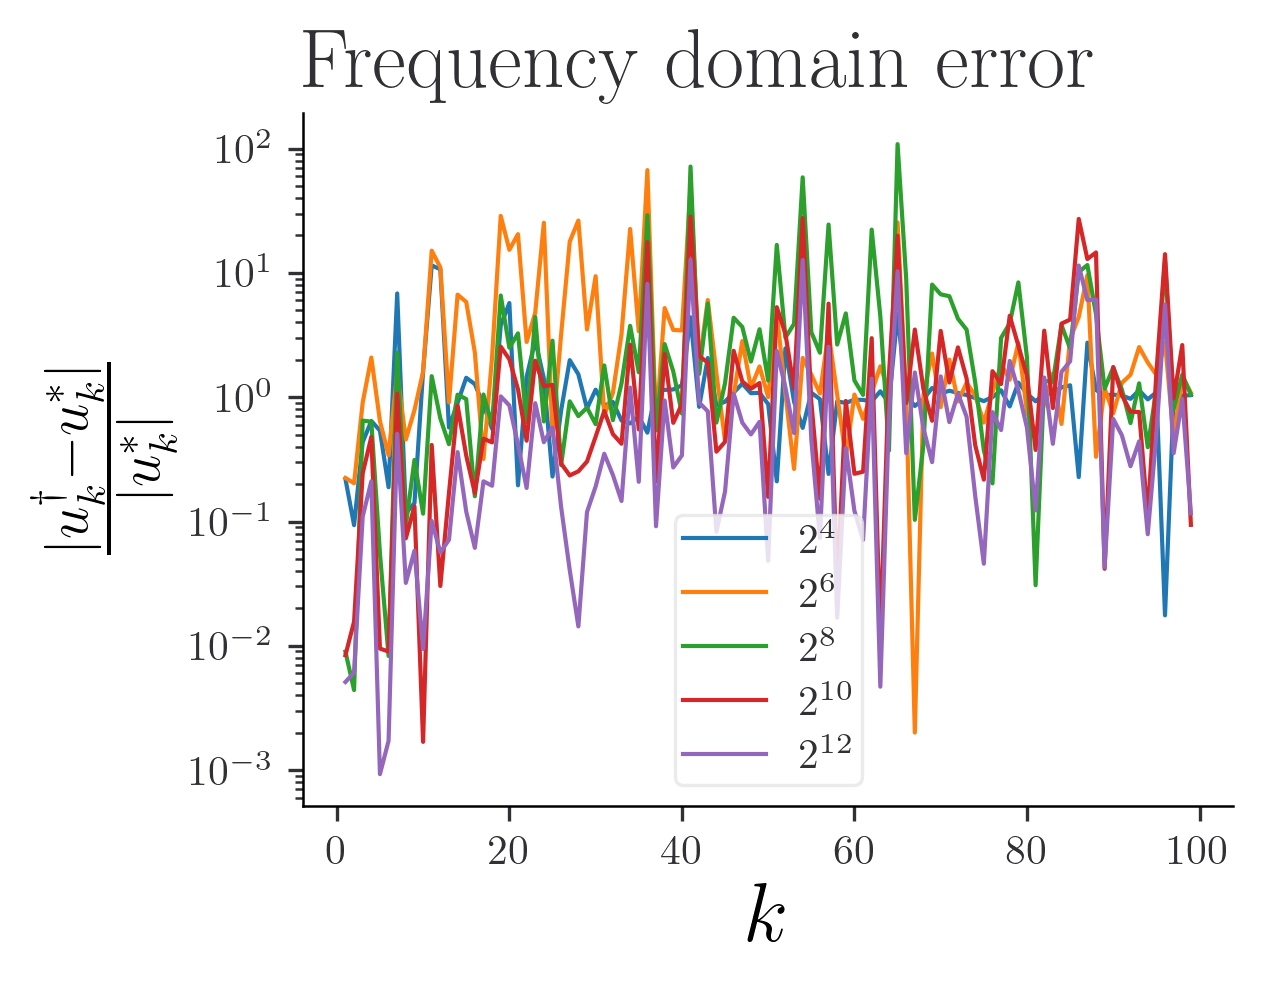

In [94]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Higher nugget

In [36]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-5


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)
    theta_22_sine = theta_22_sine[:-1, :-1] # remove the last spurious element
    theta_12_sine = vmap_dst(theta_12)
    theta_12_sine = theta_12_sine[:, :-1] # remove the last spurious element
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior[:, :-1] # remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = discrete_sine_transform(pred)[:-1]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:02<00:21,  2.71s/it]

32


 22%|██▏       | 2/9 [00:05<00:19,  2.81s/it]

64


 33%|███▎      | 3/9 [00:06<00:10,  1.75s/it]

128


 44%|████▍     | 4/9 [00:06<00:06,  1.24s/it]

256


 56%|█████▌    | 5/9 [00:07<00:03,  1.03it/s]

512


 67%|██████▋   | 6/9 [00:07<00:02,  1.25it/s]

1024


 78%|███████▊  | 7/9 [00:07<00:01,  1.44it/s]

2048


 89%|████████▉ | 8/9 [00:08<00:00,  1.58it/s]

4096


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


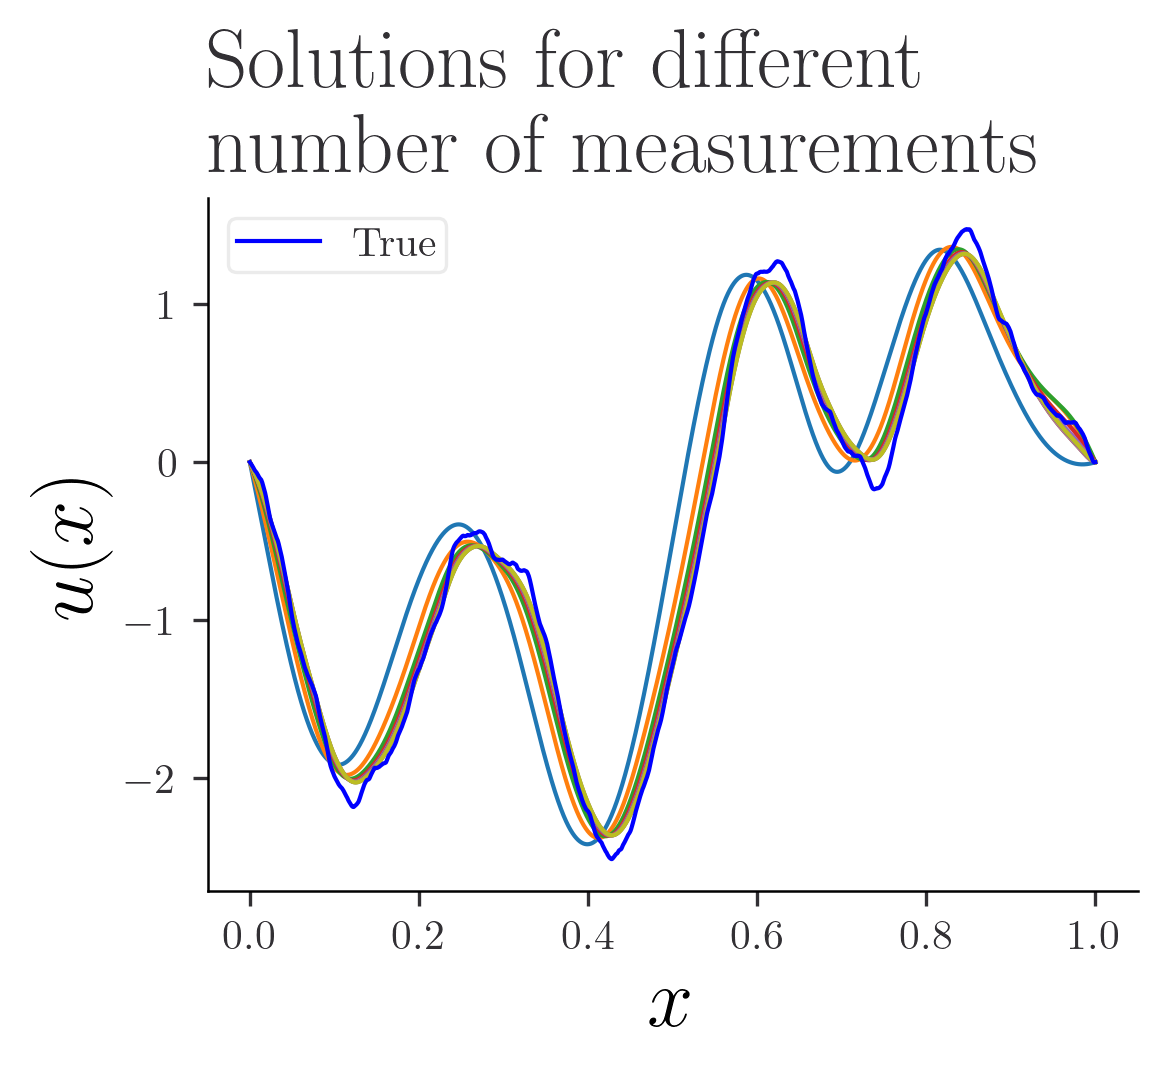

In [37]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [38]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.265


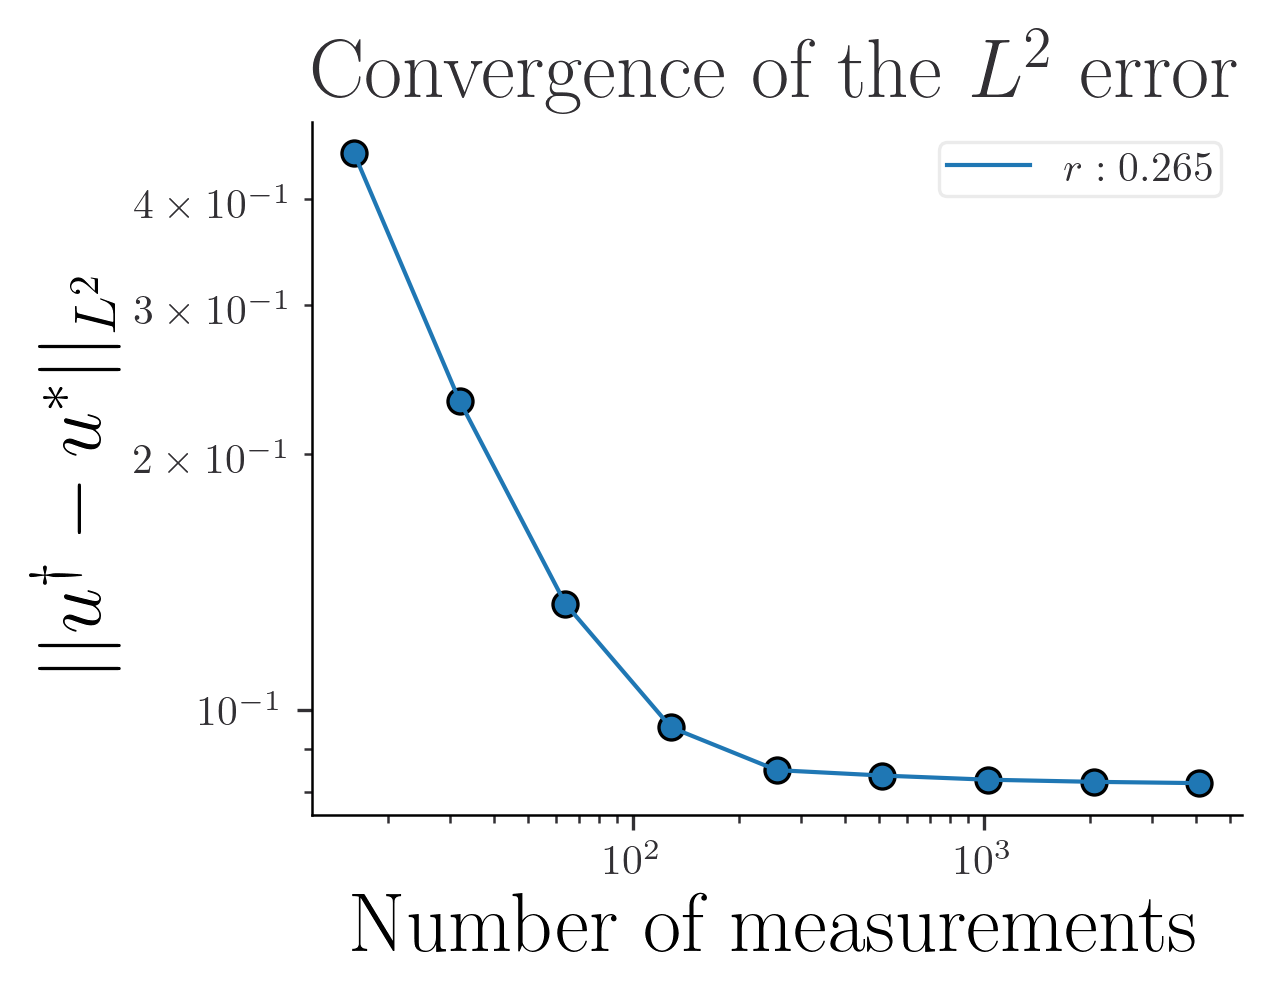

In [39]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


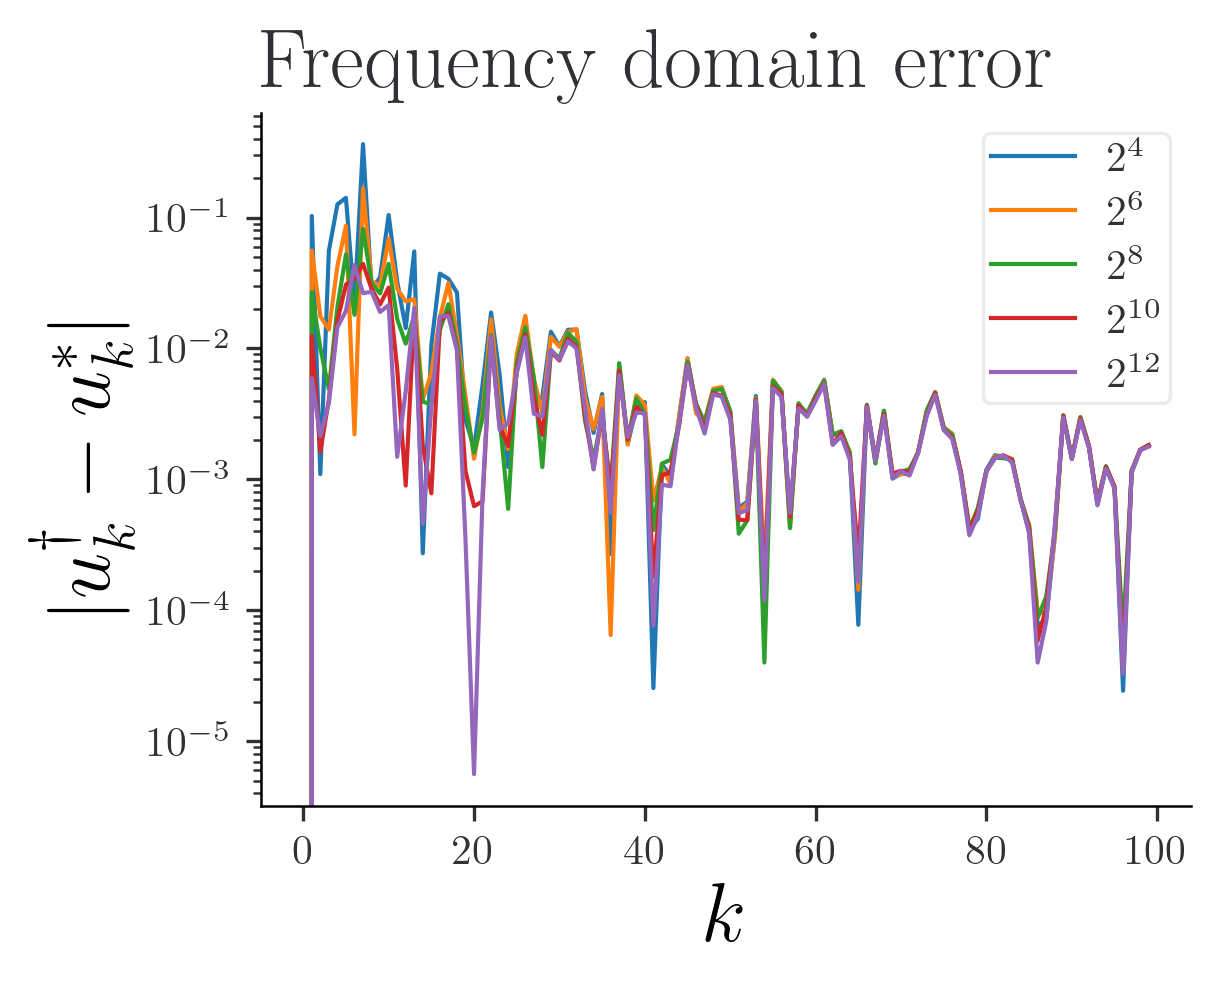

In [40]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


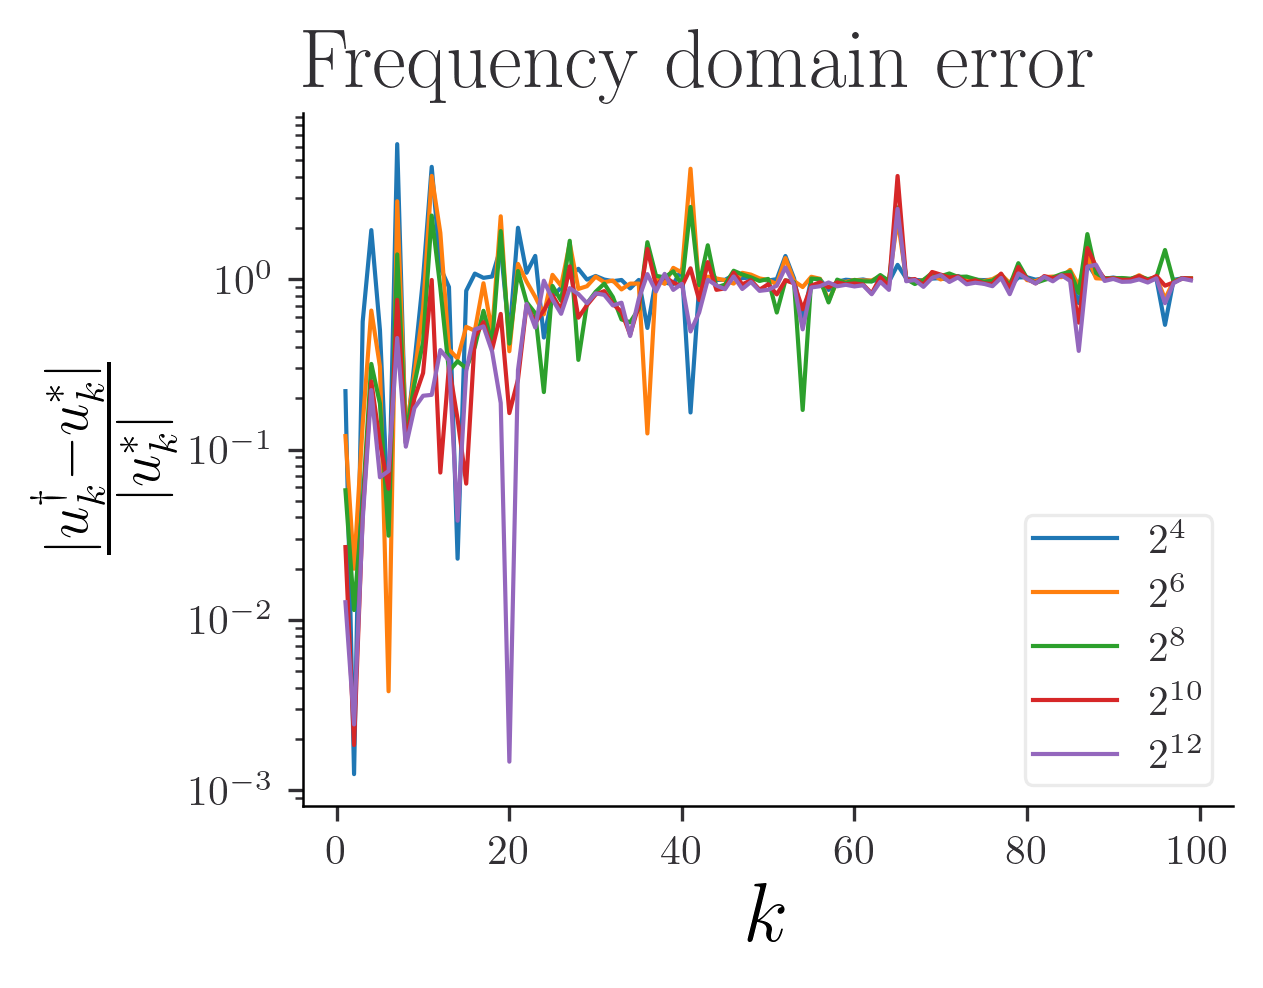

In [41]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Using the $H^{-1}$ norm

We recall that 

$$
|| \xi||^2_{H^{-1}} = \sum_{j=1}^\infty \xi_j^2 \lambda_j^{-1} \propto \sum_{j=1}^\infty \xi_j^2 j^{-2}
$$

In [53]:
jnp.arange(1, n_meas)**2*1e-12

Array([1.0000000e-12, 4.0000000e-12, 9.0000000e-12, ..., 1.6752649e-05,
       1.6760836e-05, 1.6769025e-05], dtype=float64, weak_type=True)

In [62]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-12


predictions = []

for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)
    theta_22_sine = theta_22_sine[:-1, :-1] # remove the last spurious element
    theta_12_sine = vmap_dst(theta_12)
    theta_12_sine = theta_12_sine[:, :-1] # remove the last spurious element
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.arange(1, n_meas+1)**2])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior[:, :-1] # remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = discrete_sine_transform(pred)[:-1]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:04,  1.95it/s]

32


 22%|██▏       | 2/9 [00:01<00:03,  1.93it/s]

64


 33%|███▎      | 3/9 [00:01<00:02,  2.03it/s]

128


 44%|████▍     | 4/9 [00:01<00:02,  2.07it/s]

256


 56%|█████▌    | 5/9 [00:02<00:01,  2.09it/s]

512


 67%|██████▋   | 6/9 [00:02<00:01,  2.06it/s]

1024


 78%|███████▊  | 7/9 [00:03<00:00,  2.05it/s]

2048


 89%|████████▉ | 8/9 [00:03<00:00,  2.08it/s]

4096


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


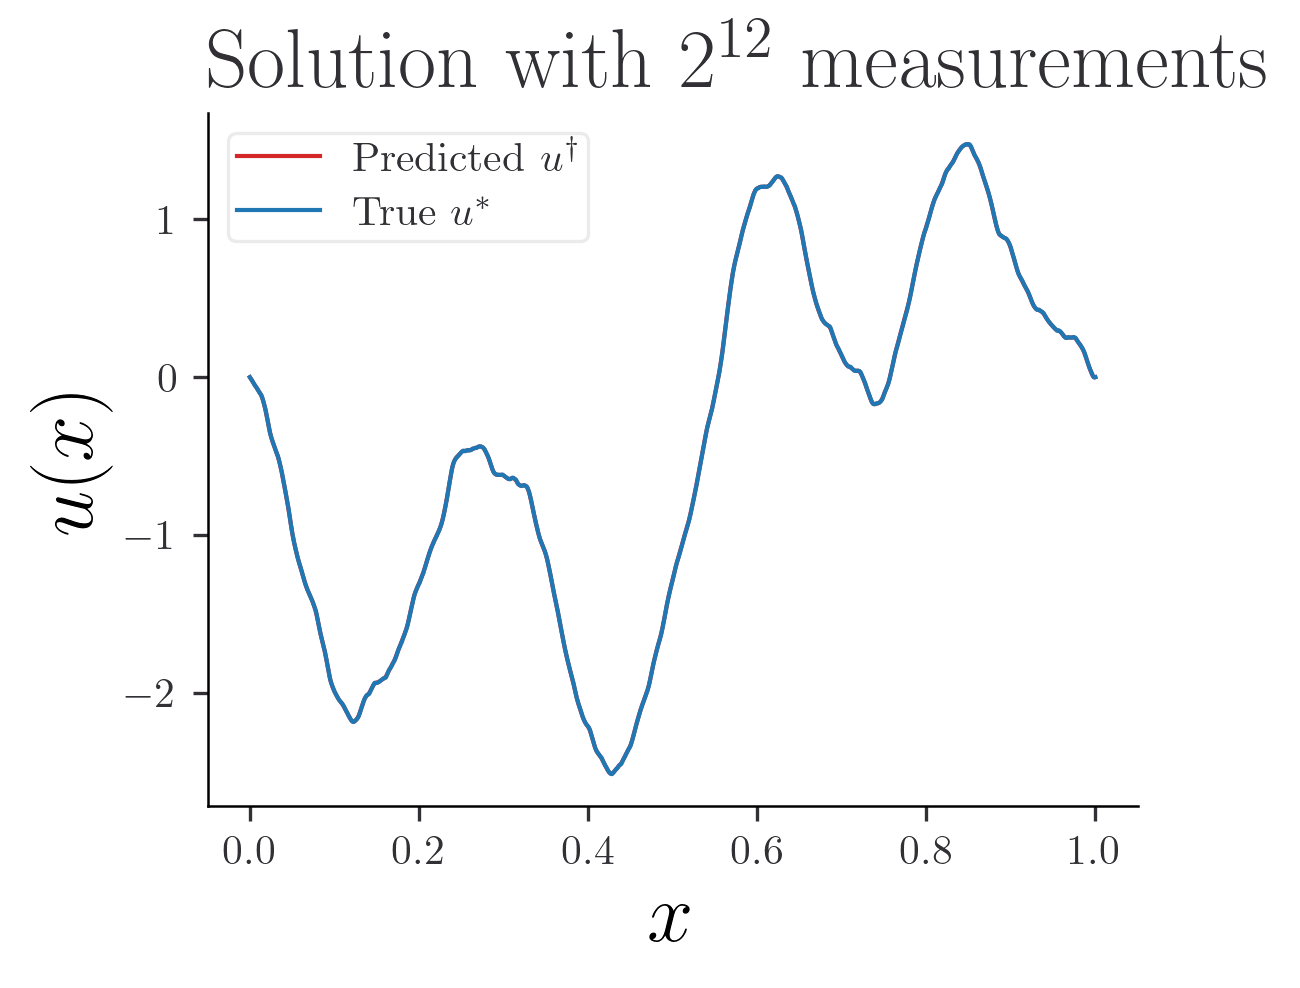

In [63]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


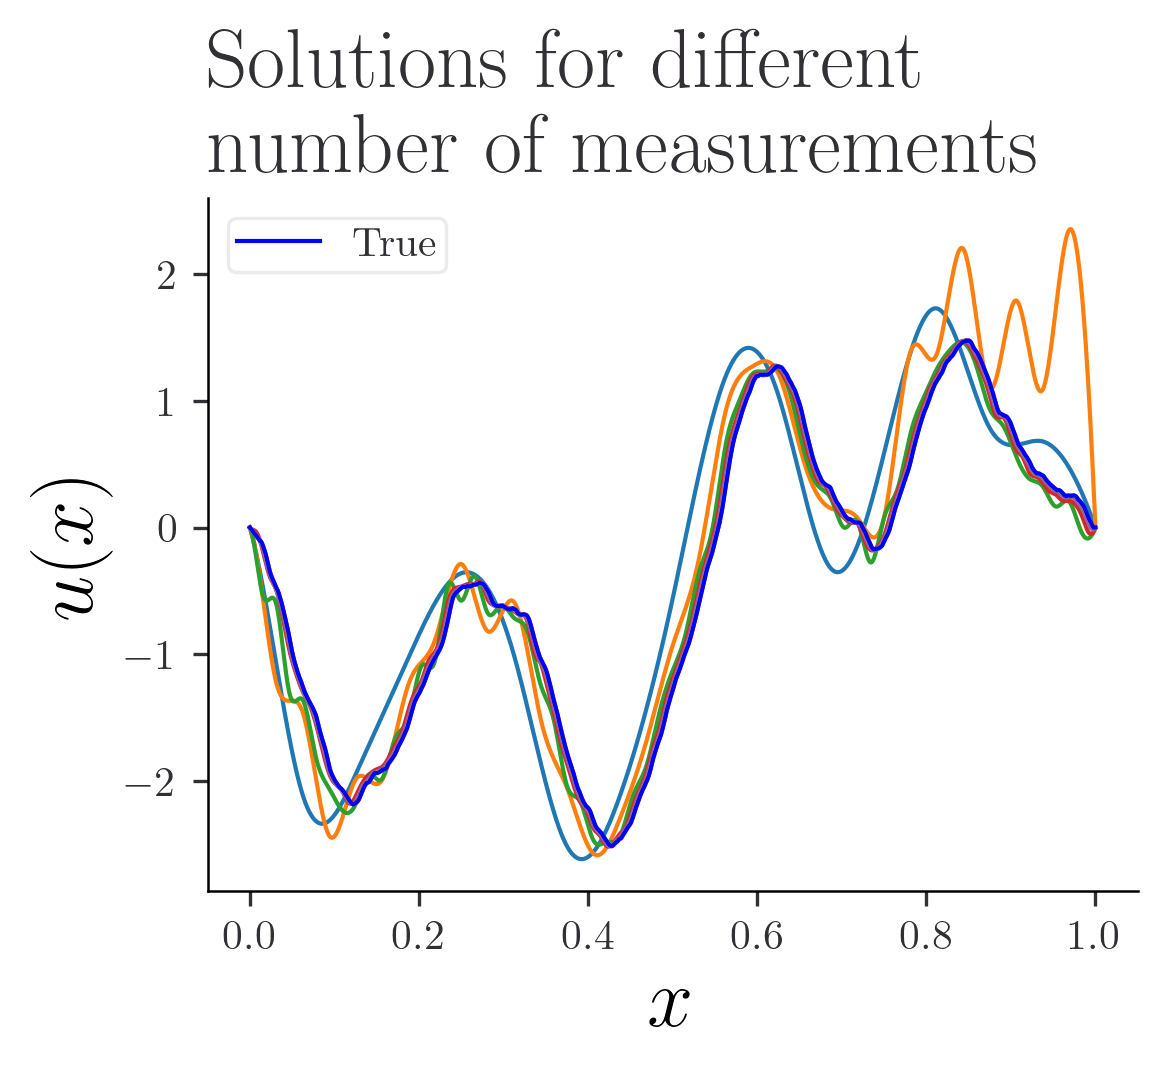

In [64]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [65]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.095


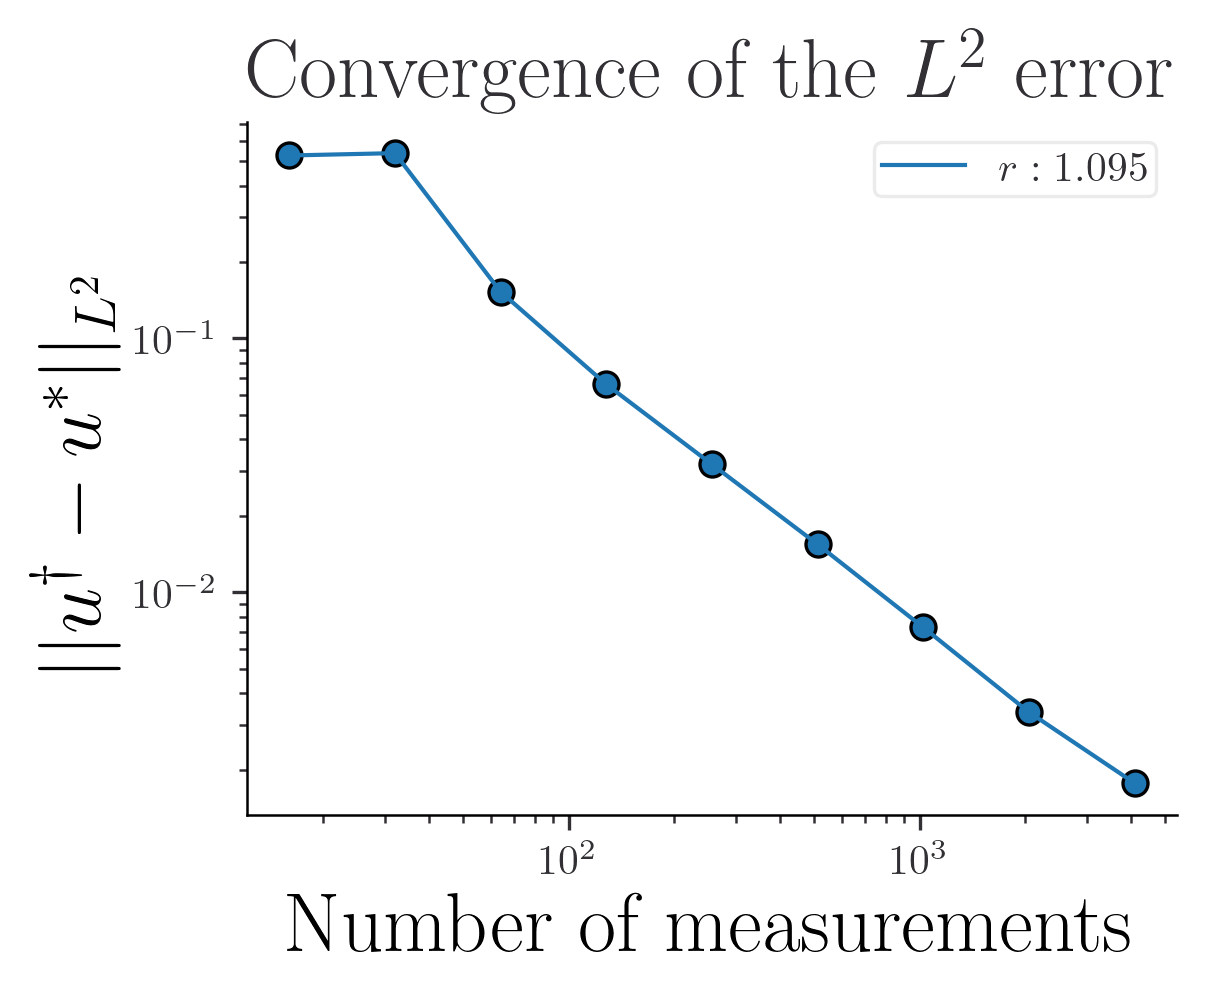

In [66]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [67]:
error

Array([0.52564695, 0.53701312, 0.15275549, 0.06599476, 0.03192504,
       0.01545274, 0.00727278, 0.00337174, 0.00177133], dtype=float64)

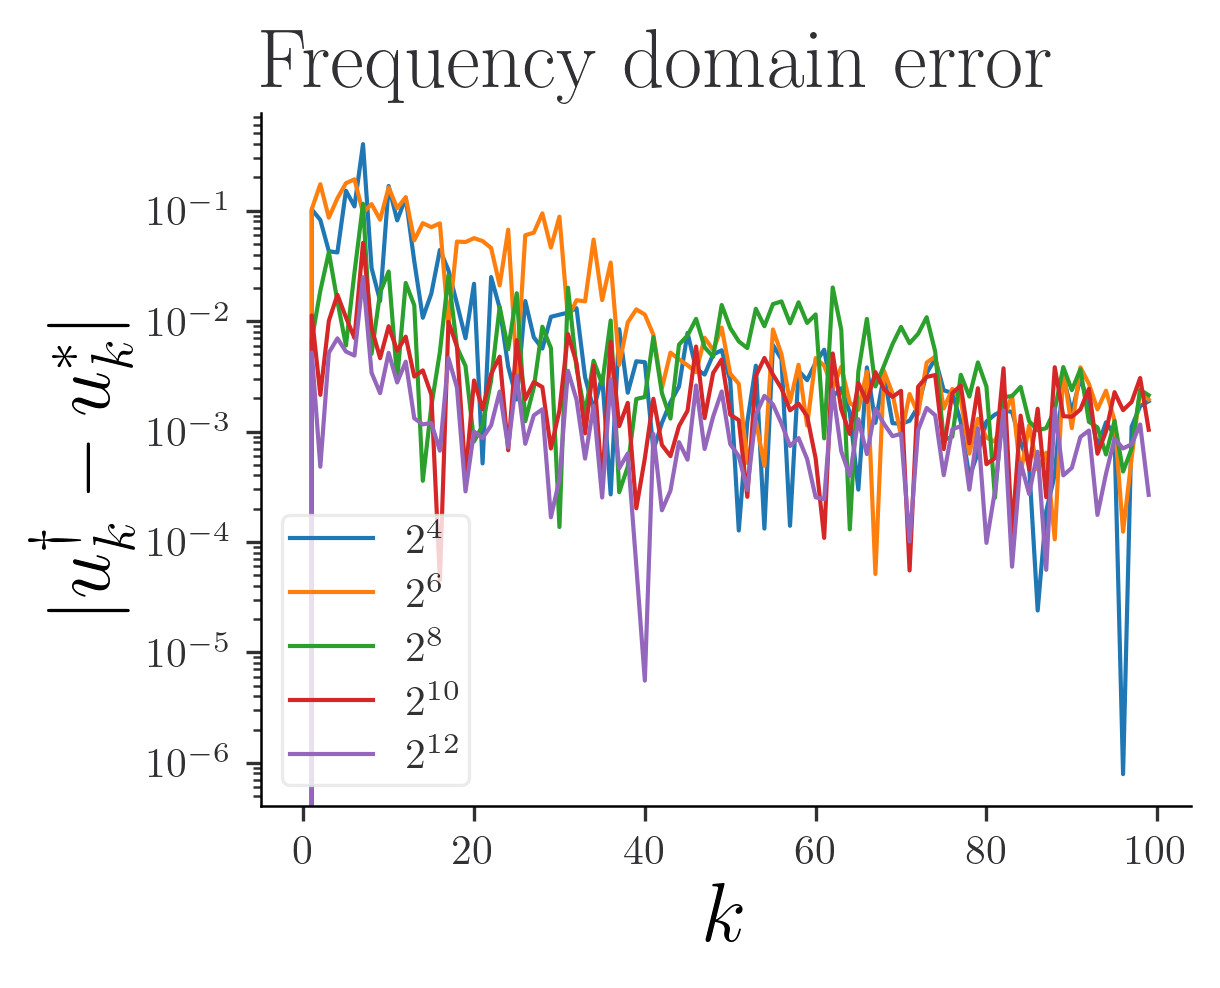

In [68]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


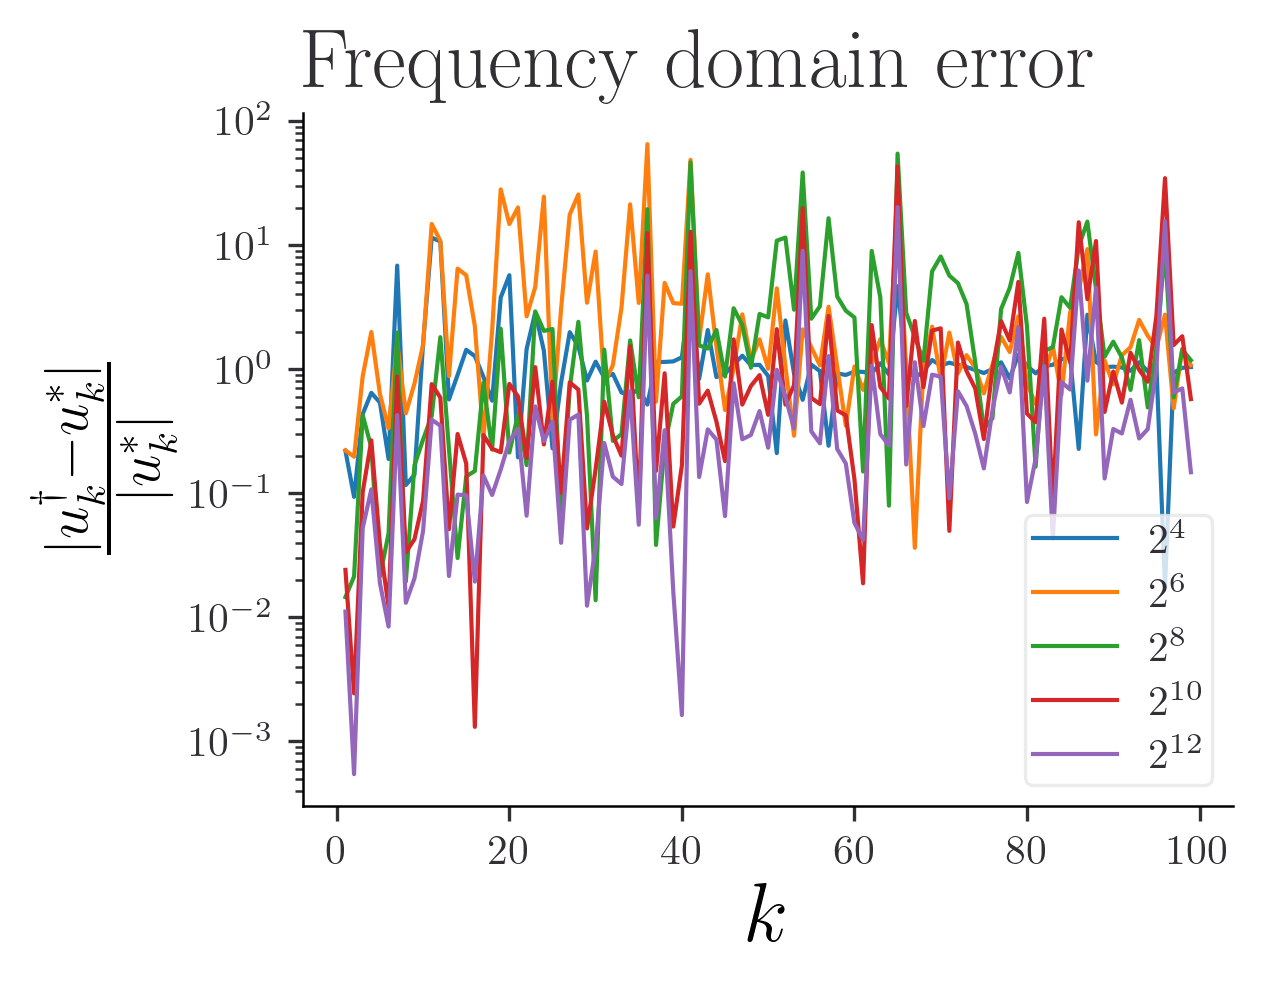

In [69]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Using the $H^{-1/2}$ norm

We recall that 

$$
|| \xi||^2_{H^{-1}} = \sum_{j=1}^\infty \xi_j^2 \lambda_j^{-1} \propto \sum_{j=1}^\infty \xi_j^2 j^{-1}
$$

In [70]:
jnp.arange(1, n_meas)**1*1e-13

Array([1.000e-13, 2.000e-13, 3.000e-13, ..., 4.093e-10, 4.094e-10,
       4.095e-10], dtype=float64, weak_type=True)

In [71]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-13


predictions = []

for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas, endpoint=False)

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_dst(vmap_dst(theta_22).T)
    theta_22_sine = theta_22_sine[:-1, :-1] # remove the last spurious element
    theta_12_sine = vmap_dst(theta_12)
    theta_12_sine = theta_12_sine[:, :-1] # remove the last spurious element
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.arange(1, n_meas+1)**1])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_dst(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior[:, :-1] # remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = discrete_sine_transform(pred)[:-1]
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:04,  1.70it/s]

32


 22%|██▏       | 2/9 [00:01<00:03,  1.91it/s]

64


 33%|███▎      | 3/9 [00:01<00:03,  1.98it/s]

128


 44%|████▍     | 4/9 [00:02<00:02,  2.01it/s]

256


 56%|█████▌    | 5/9 [00:02<00:01,  2.01it/s]

512


 67%|██████▋   | 6/9 [00:03<00:01,  2.02it/s]

1024


 78%|███████▊  | 7/9 [00:03<00:00,  2.03it/s]

2048


 89%|████████▉ | 8/9 [00:03<00:00,  2.04it/s]

4096


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


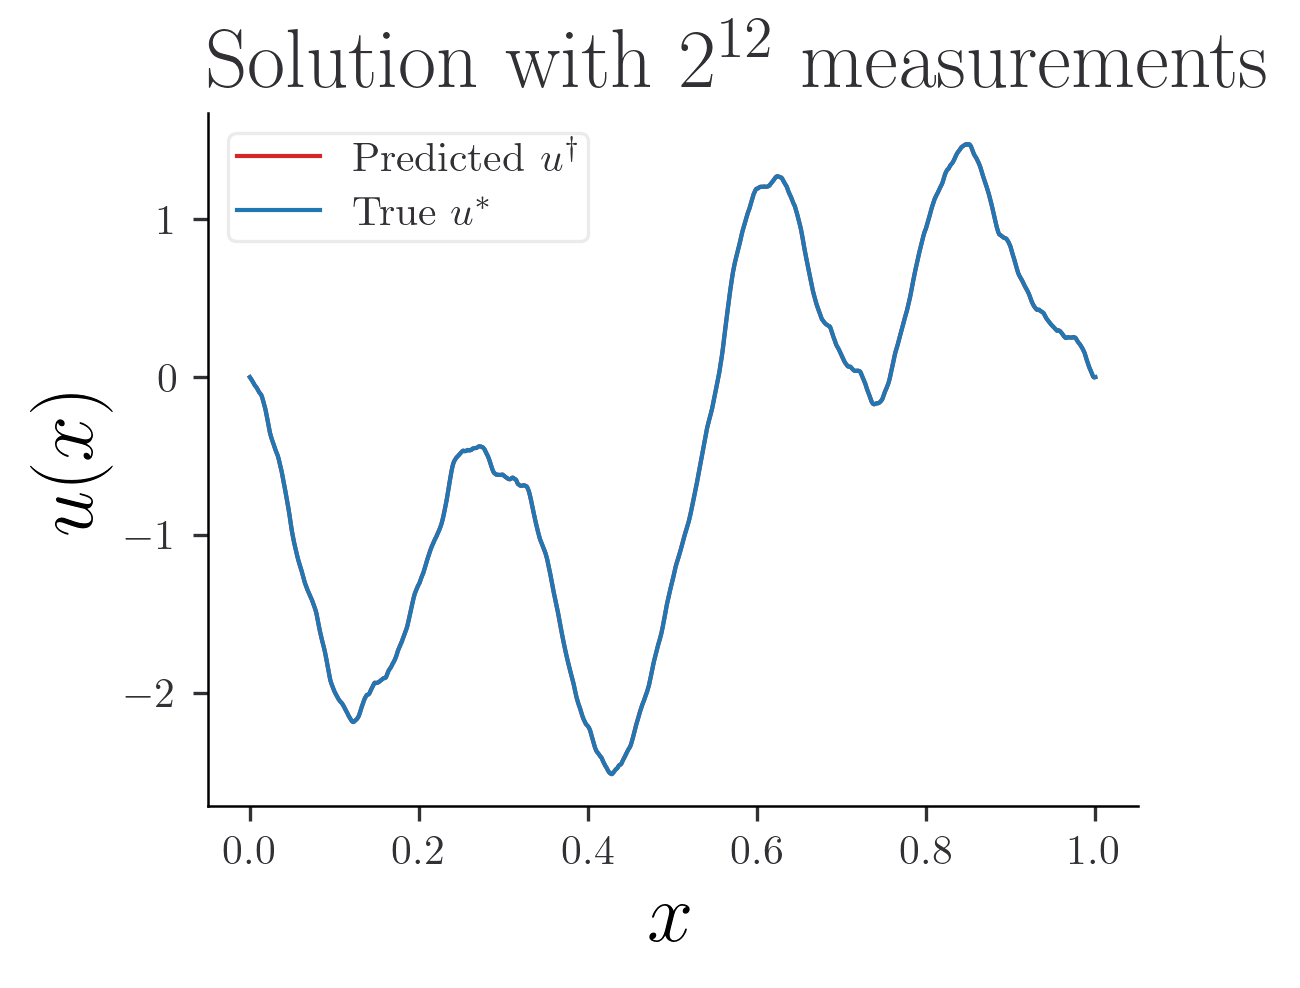

In [72]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


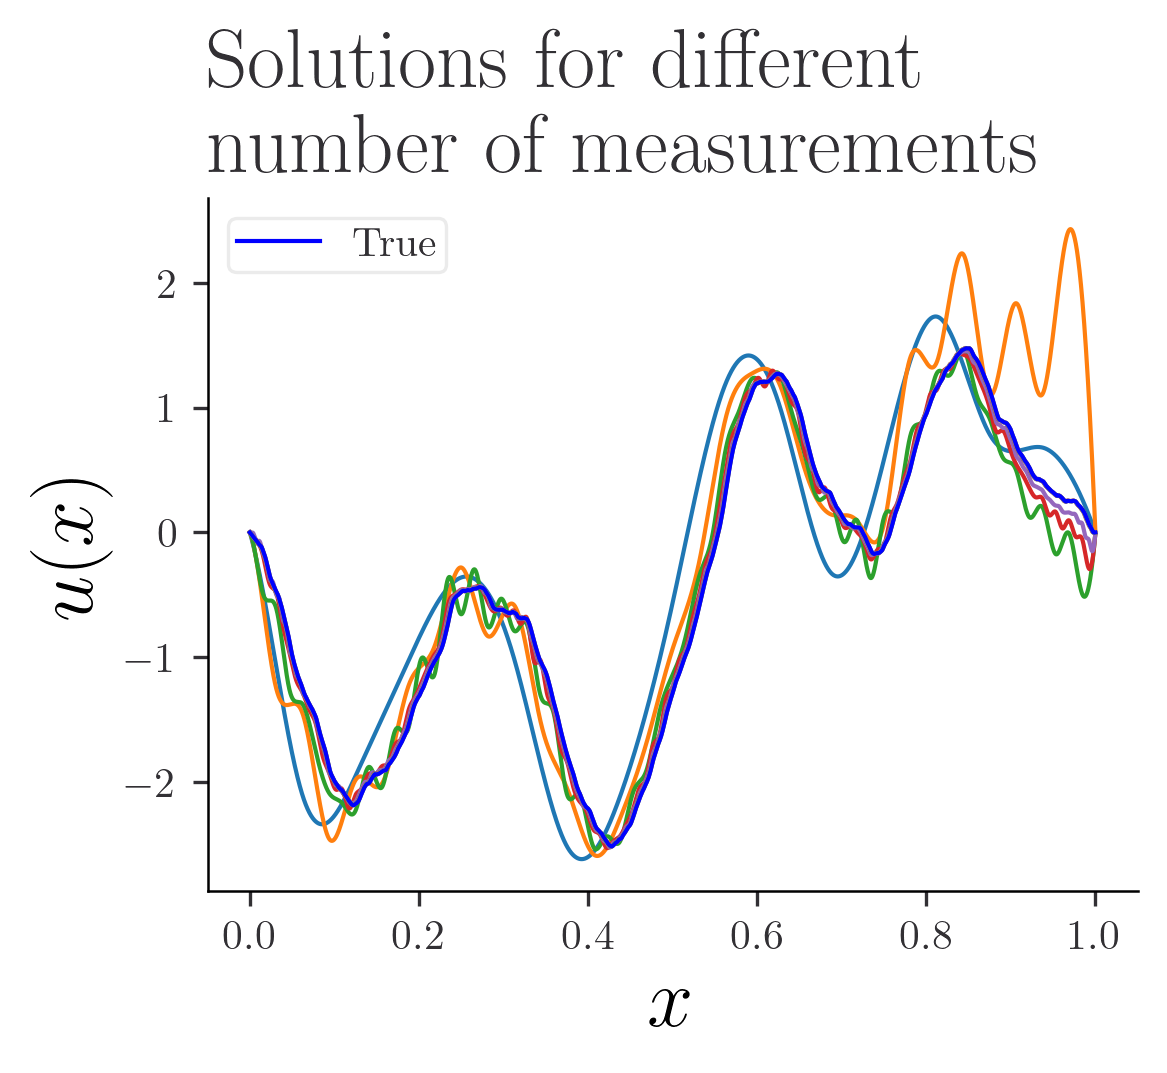

In [73]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [74]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.183


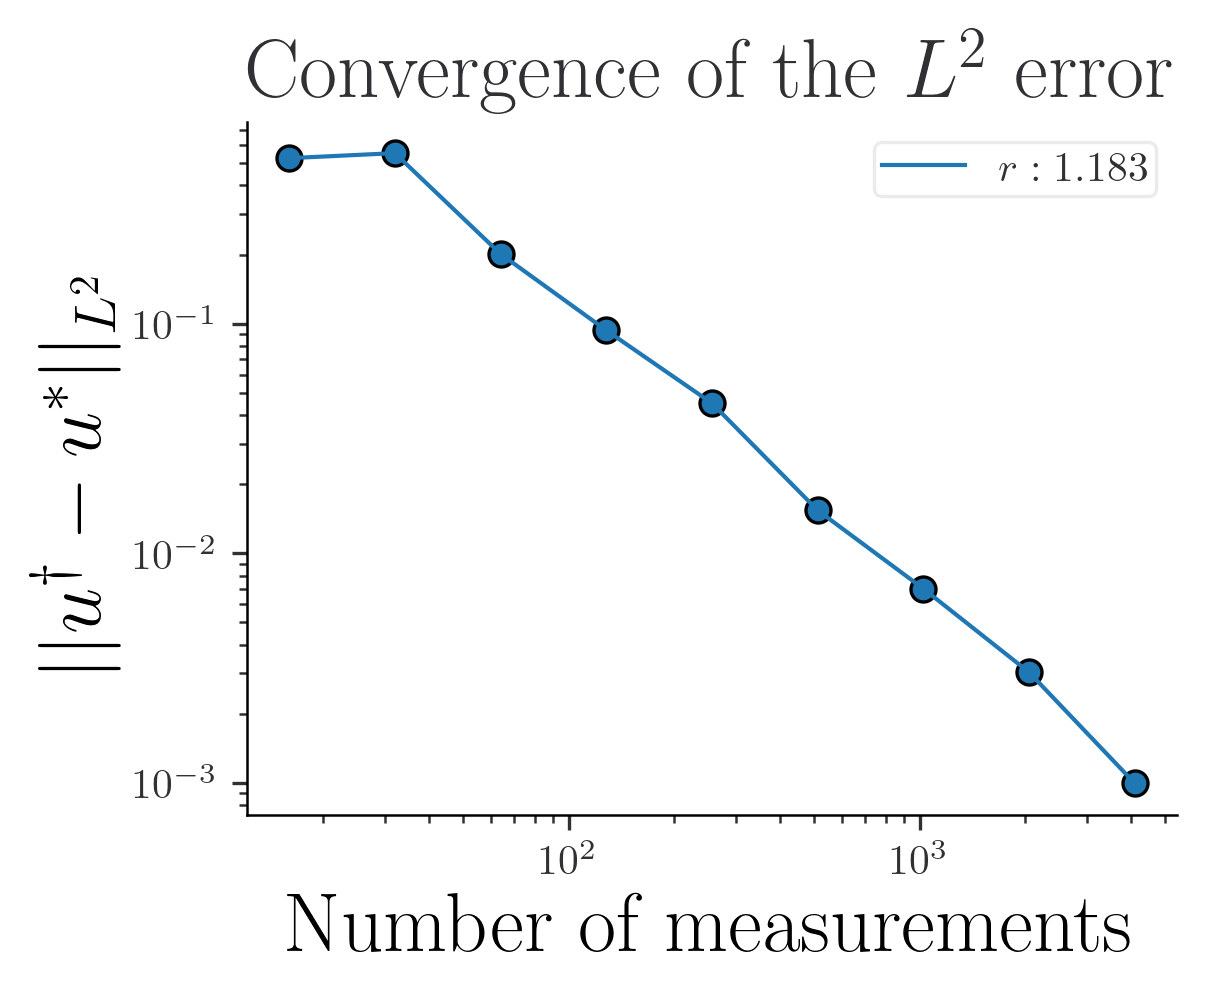

In [75]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [76]:
error

Array([0.5256712 , 0.55283213, 0.20120469, 0.09359442, 0.0450519 ,
       0.01540621, 0.00701873, 0.00303677, 0.00099858], dtype=float64)

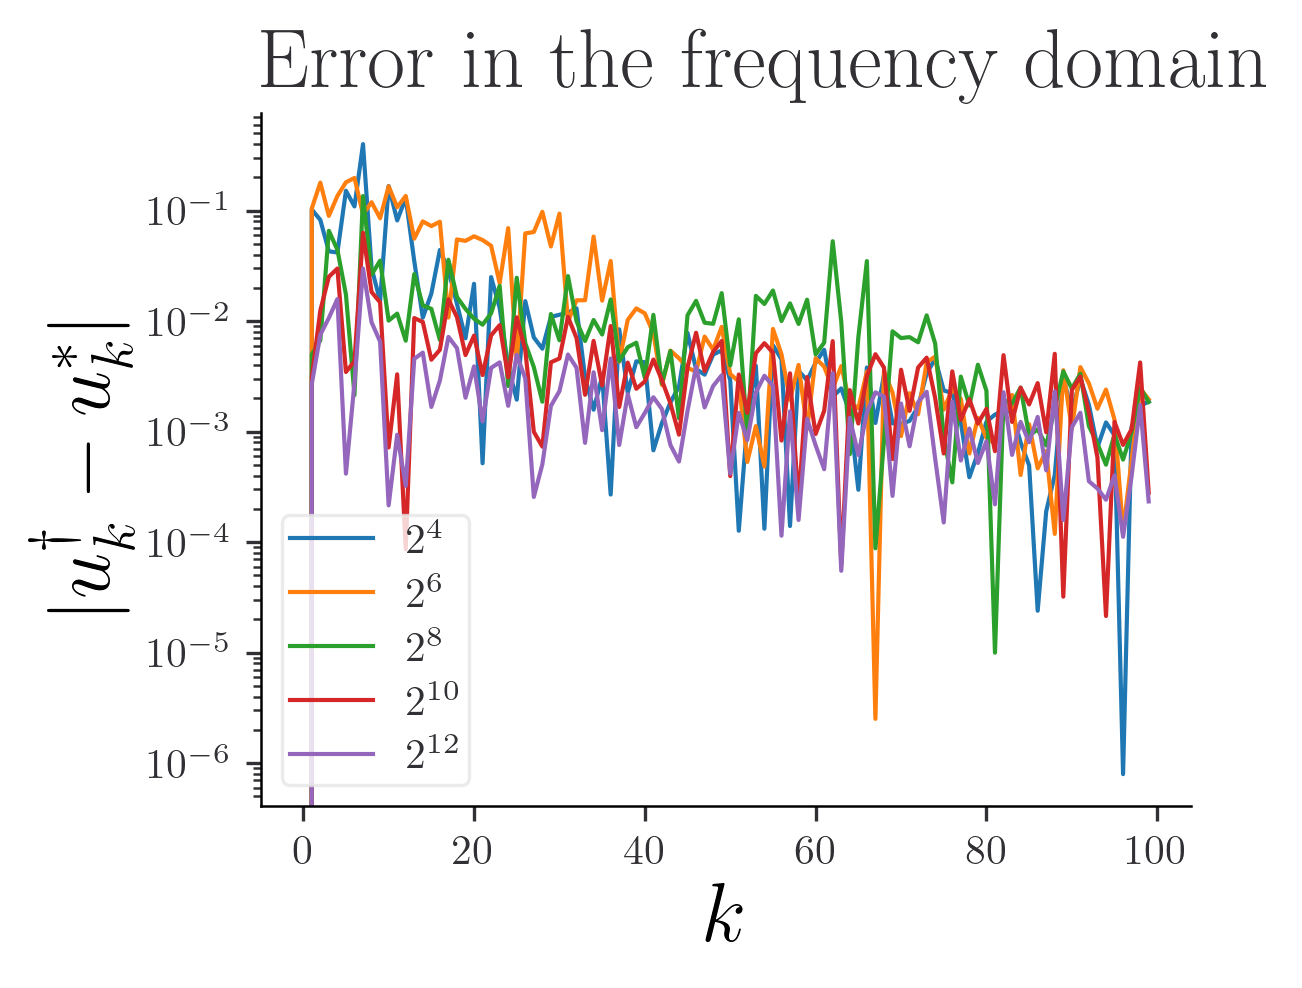

In [77]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Error in the frequency domain")
plt.show()


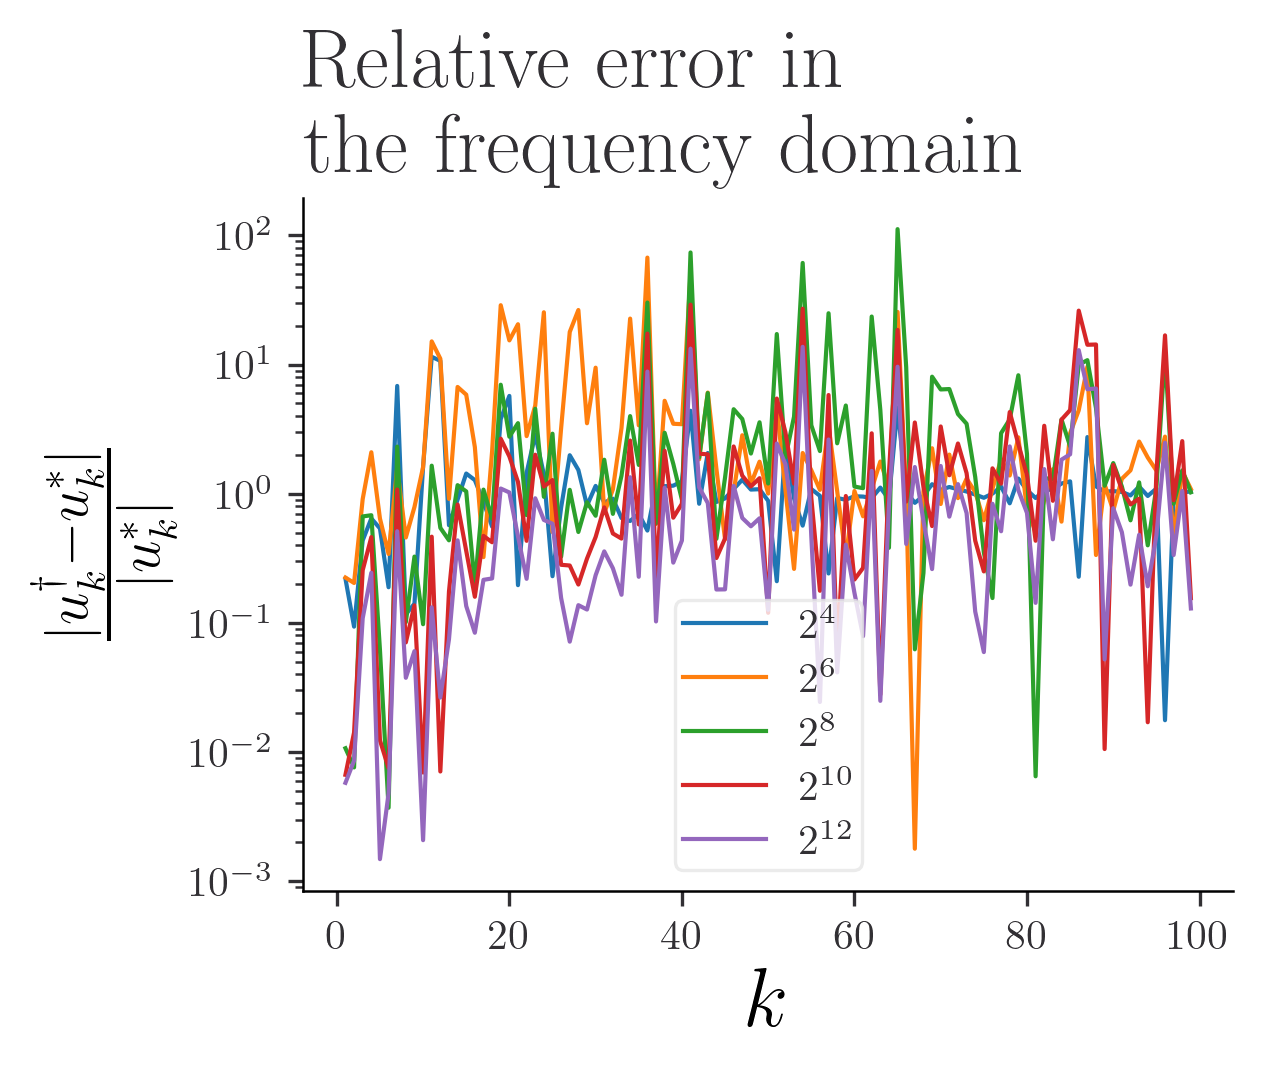

In [78]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title("Relative error in \n the frequency domain")
plt.show()